In [8]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
print(now_str())
print(torch.__version__)

def reproject(params, vertices, distort=False):
    R = params['R']
    T = params['T']
    fx = params['fx']
    fy = params['fy']
    cx = params['cx']
    cy = params['cy']

    E = np.array([
        [R[0,0], R[0,1], R[0,2], T[0]], 
        [R[1,0], R[1,1], R[1,2], T[1]], 
        [R[2,0], R[2,1], R[2,2], T[2]], 
        [0, 0, 0, 1]]).astype('double')
    
    if distort:
        k1 = params['k1']
        k2 = params['k2']
        k3 = params['k3']
        p1 = params['p1']
        p2 = params['p2']
        
    img_pts = []
    for i in range(len(vertices)):
        v = np.array(vertices[i])

        # extrinsics
        v4 = E.dot(np.array([v[0], v[1], v[2], 1]).astype('double'))
        xp = v4[0] / v4[2]
        yp = v4[1] / v4[2]

        if distort:
            # intrinsics
            r2 = xp**2 + yp**2
            ## radial
            radial_dist = 1 + k1*(r2) + k2*(r2*r2) + k3*(r2*r2*r2)

            ## tangential
            tan_x = p2 * (r2 + 2.0 * xp * xp) + 2.0 * p1 * xp * yp
            tan_y = p1 * (r2 + 2.0 * yp * yp) + 2.0 * p2 * xp * yp

            xp = xp * radial_dist + tan_x
            yp = yp * radial_dist + tan_y
            
        u = fx * xp + cx
        v = fy * yp + cy
        pr = 1
        nr = 0
        if (-4000*nr < u and u < pr*4000) and (-2160*nr < v and v < pr*2160):
            img_pts.append(np.array([u, v]))
    img_pts = np.array(img_pts)
    return img_pts

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


9.2
[06/19 15:03:19]
1.4.0


In [9]:
print('torch.cuda.is_available():',torch.cuda.is_available())
print('----- torch.cuda.empty_cache() -----')

torch.cuda.empty_cache()
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

torch.cuda.is_available(): True
----- torch.cuda.empty_cache() -----
torch.cuda.memory_reserved(): 25.17 Mb
torch.cuda.memory_allocated(): 23.43 Mb
torch.cuda.memory_cached(): 25.17 Mb


# Settings

In [19]:
device = torch.device("cuda:0")

cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
cam_path = r'D:\CalibrationData\CameraCalibration\2019_12_13_Lada_Capture_k1k2k3p1p2\FinalCamParams\cam_params.json'
#mesh_dir = r'D:\1_Projects\200325_PyTorch3d_Projects\21_data\input\200616_SilhoutteFitted\f_v_vn_vt'
mesh_dir = r'D:\1_Projects\200325_PyTorch3d_Projects\0_data\output\200619_SilFittedMesh_vtAdded'
img_dir = 'D:\Pictures\2019_12_13_Lada_Capture\png\grayPng'
img_names = ['03052', '03067', '04735', '06550', '06250']
clean_plate_dir = r'D:\Pictures\2019_12_13_Lada_Capture\CleanPlates\undistorted'
texturemap_path = None

texturemap_shape = (1024, 1024, 1)
image_size = 1080

# input image size
actual_img_shape = (2160, 4000)

print('Meshes:')
mesh_paths = []
for img_name in img_names:
    mesh_paths.append(mesh_dir + '\\{}.obj'.format(img_name))
    print(mesh_paths[-1])
n_forwards = len(img_names)*len(cams)

batch_size = 1
n_batch = int(n_forwards / batch_size)
print('{} renderes'.format(n_forwards), ', n_batch={}, batch_size={}'.format(n_batch, batch_size))

Meshes:
D:\1_Projects\200325_PyTorch3d_Projects\0_data\output\200619_SilFittedMesh_vtAdded\03052.obj
D:\1_Projects\200325_PyTorch3d_Projects\0_data\output\200619_SilFittedMesh_vtAdded\03067.obj
D:\1_Projects\200325_PyTorch3d_Projects\0_data\output\200619_SilFittedMesh_vtAdded\04735.obj
D:\1_Projects\200325_PyTorch3d_Projects\0_data\output\200619_SilFittedMesh_vtAdded\06550.obj
D:\1_Projects\200325_PyTorch3d_Projects\0_data\output\200619_SilFittedMesh_vtAdded\06250.obj
80 renderes , n_batch=80, batch_size=1


# load cameras

In [20]:
def load_cameras(cam_path, device, actual_img_shape):
    print('actual_img_shape:',actual_img_shape)
    h = actual_img_shape[0]
    w = actual_img_shape[1]
    img_size = min(w, h)
    
    # load cameras
    cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

    with open(cam_path, 'r') as f:
        j = json.load(f)
        camera_params = j['cam_params']

    cam_params = []
    Rs, Ts, focal_lengths, principal_points = [], [], [], []
    for cam_idx, cam in enumerate(cams):
        cam_param = camera_params[str(cam_idx)]
        # for undistortion
        fx = cam_param['fx']
        fy = cam_param['fy']
        cx = cam_param['cx']
        cy = cam_param['cy']
        k1 = cam_param['k1']
        k2 = cam_param['k2']
        k3 = cam_param['k3']
        p1 = cam_param['p1']
        p2 = cam_param['p2']
        
        rvec = np.float32(cam_param['rvec'])
        T = np.float32(cam_param['tvec'])
        R, _ = cv2.Rodrigues(rvec)
        Rs.append(R.T)
        Ts.append(T)
        
        cx_corrected = cx*2/img_size - w/img_size
        cy_corrected = cy*2/img_size - h/img_size
        fx_corrected = fx*2/img_size
        fy_corrected = fy*2/img_size
        principal_point = np.array([cx_corrected, cy_corrected]).astype(np.float32)
        focal_length = np.array([fx_corrected, fy_corrected]).astype(np.float32)
        focal_lengths.append(focal_length)
        principal_points.append(principal_point)

        K = np.float32([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
        dist = np.float32([k1, k2, p1, p2, k3])
        cam_params.append({'K': K, 'dist': dist, 'R': R, 'T': T, 'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy})
    
    R_torch = torch.from_numpy(np.array(Rs).astype(np.float32))
    T_torch = torch.from_numpy(np.array(Ts).astype(np.float32))
    focal_length = torch.from_numpy(np.array(focal_lengths).astype(np.float32))
    principal_point = torch.from_numpy(np.array(principal_points).astype(np.float32))
    out_for_torch = {'R': R_torch, 'T': T_torch, 'fl': focal_length, 'pp': principal_point}
    return cam_params, out_for_torch

cam_params, cams_torch = load_cameras(cam_path, device, actual_img_shape)
print(len(cam_params), ':', cam_params[0].keys())
print(cams_torch.keys())
print(cams_torch['R'].shape)

actual_img_shape: (2160, 4000)
16 : dict_keys(['K', 'dist', 'R', 'T', 'fx', 'fy', 'cx', 'cy'])
dict_keys(['R', 'T', 'fl', 'pp'])
torch.Size([16, 3, 3])


# V1: Generate target images, using cv2.erode()

In [21]:
def gen_target_images(device, render_data, image_size):
    raster_settings = RasterizationSettings(
        image_size=image_size, 
        blur_radius=0, 
        faces_per_pixel=1, 
        bin_size = 0, # this setting controls whether naive or coarse-to-fine rasterization is used
        max_faces_per_bin = None  # this setting is for coarse rasterization
    )
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
        cameras=None,
        raster_settings=raster_settings
        ),
        shader=SoftSilhouetteShader(BlendParams(sigma=1e-4, gamma=1e-4))
    )
    
    images = []
    for d in render_data:
        meshes = d['meshes']
        cameras = d['cameras']
        image = renderer(meshes_world=meshes, cameras=cameras)[..., 3]
        images.append(image.detach().squeeze().cpu().numpy())
    images = np.stack(images, axis=0).astype(np.float32)
    return images

def init_camera_batches(device, cams_torch, n_batch, batch_size):
    cams = []
    for batch_idx in range(n_batch):
        i0 = batch_idx*batch_size
        i1 = i0 + batch_size
        R = cams_torch['R'][i0:i1]
        T = cams_torch['T'][i0:i1]
        focal_length = cams_torch['fl'][i0:i1]
        principal_point = cams_torch['pp'][i0:i1]
        
        cameras = SfMPerspectiveCameras(device=device, R=R, T=T, principal_point=principal_point, focal_length=focal_length)
        cams.append(cameras)
    return cams

def load_mesh(device, mesh_path):
    verts, faces, aux = load_obj(mesh_path)
    faces_idx = faces.verts_idx

    verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
    faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)

    mesh = Meshes(
        verts=[verts.to(device)],   
        faces=[faces_idx.to(device)]
    )
    return mesh
def binarize(np_imgs):
    out = []
    for i in range(np_imgs.shape[0]):
        out.append((np_imgs[i] > 0).astype(np.float32))
    return np.float32(out)

image_refs = {}
for img_idx, img_name in enumerate(img_names):
    print(img_name)
    mesh_path = mesh_paths[img_idx]
    mesh_target = load_mesh(device, mesh_path)
    
    n_batch_temp = 16
    batch_size_temp = 1
    cameras = init_camera_batches(device, cams_torch, n_batch_temp, batch_size_temp)

    render_data = []
    for i in range(len(cameras)):
        data = {'meshes': mesh_target.extend(batch_size), 'cameras': cameras[i]}
        render_data.append(data)

    img_ref = gen_target_images(device, render_data, image_size)
    img_ref = binarize(img_ref)
    image_refs[img_name] = img_ref
for k, v in image_refs.items():
    print(k, v.shape)
# img_name = '03052'
# image_refs = {'03052': image_refs}
# n_imgs = image_refs[img_name].shape[0]
# n_cols = 8
# n_rows = int(n_imgs/n_cols)
# fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))
# ax = ax.ravel()
# for i in range(n_imgs):
#     img = cv2.flip(image_refs[img_name][i], -1)
    
#     ax[i].imshow(img, cmap='gray')
#     ax[i].set_title('{}'.format(img.shape))
# plt.show()

03052
03067
04735
06550
06250
03052 (16, 1080, 1080)
03067 (16, 1080, 1080)
04735 (16, 1080, 1080)
06550 (16, 1080, 1080)
06250 (16, 1080, 1080)


### get contours

In [22]:
kernel = np.ones((5, 5), np.uint8)
contours = {}
for img_name in img_names:
    cnts = []
    for i in range(image_refs[img_name].shape[0]):
        img = (image_refs[img_name][i]*255).astype(np.uint8)
        dilation = cv2.dilate(img, kernel, iterations=1)
        erosion = cv2.erode(img, kernel, iterations=1)
        #cnt = img - erosion
        cnt = dilation - erosion
        cnts.append(cnt)
    contours[img_name] = np.float32(cnts)
for k, v in contours.items():
    print(k, v.shape)
# n_imgs = contours[img_name].shape[0]
# n_cols = 8
# n_rows = int(n_imgs/n_cols)
# fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))
# ax = ax.ravel()
# for i in range(n_imgs):
#     img = cv2.flip(contours[img_name][i], -1)
    
#     ax[i].imshow(img, cmap='gray')
#     ax[i].set_title('{}'.format(img.shape))
# plt.show()

03052 (16, 1080, 1080)
03067 (16, 1080, 1080)
04735 (16, 1080, 1080)
06550 (16, 1080, 1080)
06250 (16, 1080, 1080)


### export png images

In [23]:
out_dir = './22_data/output'
for k, cnts in contours.items():
    print(k)
    for img_idx in range(cnts.shape[0]):
        out_path = out_dir + '/{}_{}.png'.format(k, img_idx)
        img = cv2.flip(cnts[img_idx], -1)
        cv2.imwrite(out_path, img)
    print(out_path)
print('Done')

03052
./22_data/output/03052_15.png
03067
./22_data/output/03067_15.png
04735
./22_data/output/04735_15.png
06550
./22_data/output/06550_15.png
06250
./22_data/output/06250_15.png
Done


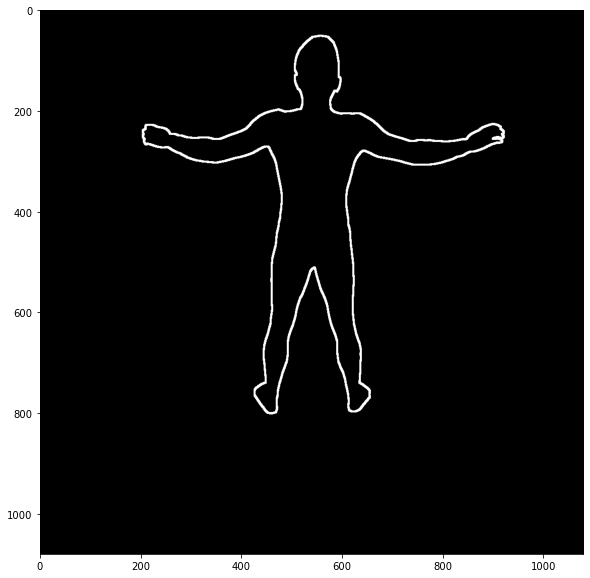

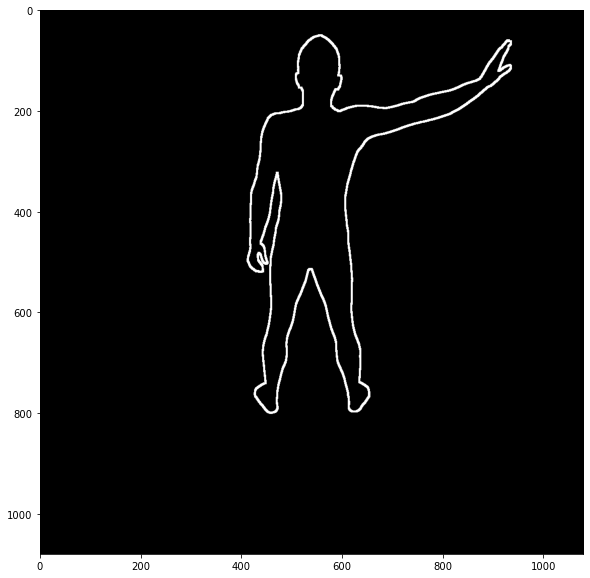

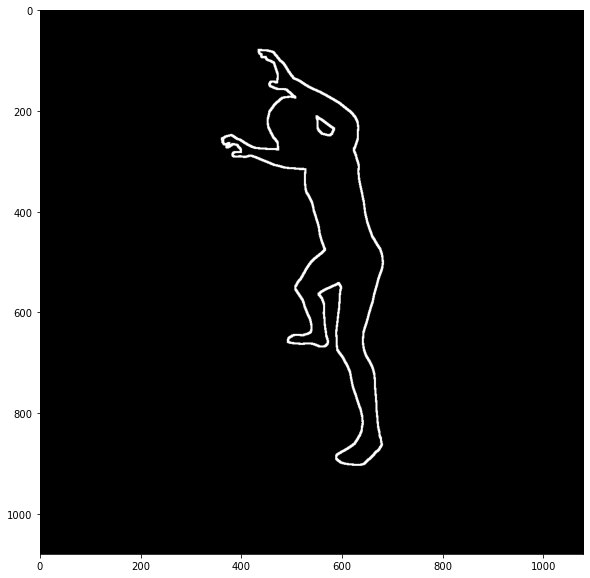

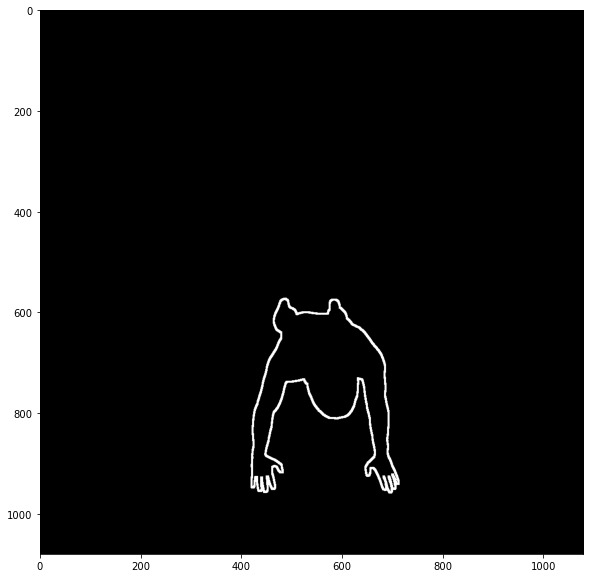

In [18]:
for k, cnts in contours.items():
    plt.figure(figsize=(10, 10))
    cnt = cv2.flip(cnts[0], -1)
    plt.imshow(cnt, cmap='gray')
    plt.show()
    


# V2: Generate target images: using shrinked mesh

  1/8  2/8  3/8  4/8  5/8  6/8  7/8  8/8
Done: (16, 1080, 1080)


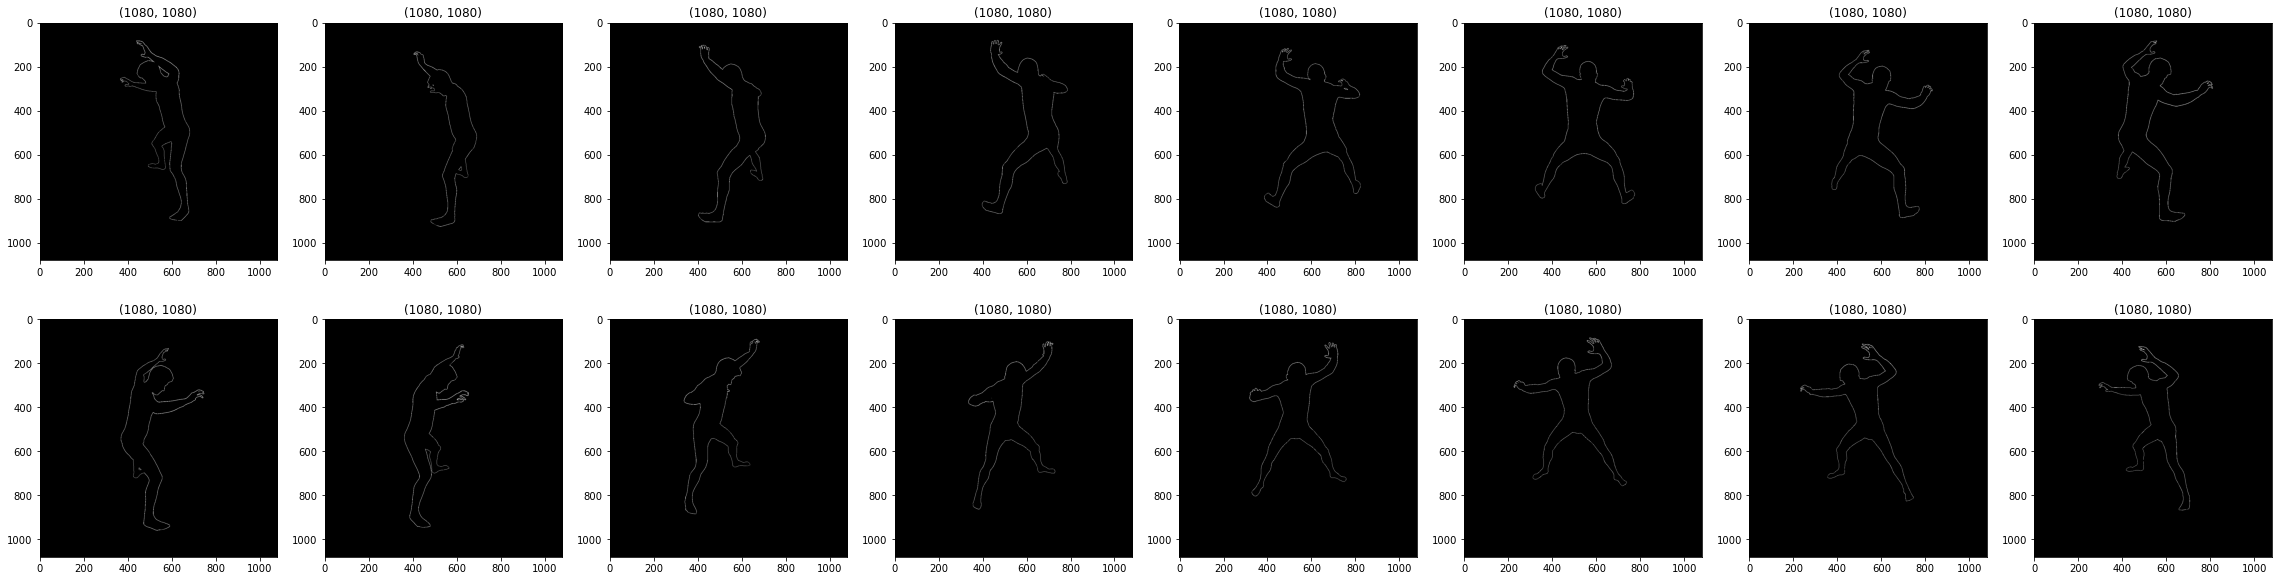

In [42]:
def gen_target_images_v2(device, render_data, image_size):
    raster_settings = RasterizationSettings(
        image_size=image_size, 
        blur_radius=0, 
        faces_per_pixel=1, 
        bin_size = 0, # this setting controls whether naive or coarse-to-fine rasterization is used
        max_faces_per_bin = None  # this setting is for coarse rasterization
    )
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
        cameras=None,
        raster_settings=raster_settings
        ),
        shader=SoftSilhouetteShader(BlendParams(sigma=1e-4, gamma=1e-4))
    )
    
    images = []
    for i, d in enumerate(render_data):
        print('  {}/{}'.format(i+1, len(render_data)), end='')
        meshes1 = d['meshes1']
        meshes2 = d['meshes2']
        cameras = d['cameras']
        image1 = renderer(meshes_world=meshes1, cameras=cameras)[..., 3]
        image2 = renderer(meshes_world=meshes2, cameras=cameras)[..., 3]
        image1 = binarize_torch(image1)
        image2 = binarize_torch(image2)
        diff = image1 - image2
        images.append(diff.detach().squeeze().cpu().numpy())
    images = np.vstack(images).astype(np.float32)
    print('\nDone:', images.shape)
    return images

def init_camera_batches(device, cams_torch, n_batch, batch_size):
    cams = []
    for batch_idx in range(n_batch):
        i0 = batch_idx*batch_size
        i1 = i0 + batch_size
        R = cams_torch['R'][i0:i1]
        T = cams_torch['T'][i0:i1]
        focal_length = cams_torch['fl'][i0:i1]
        principal_point = cams_torch['pp'][i0:i1]
        
        cameras = SfMPerspectiveCameras(device=device, R=R, T=T, principal_point=principal_point, focal_length=focal_length)
        cams.append(cameras)
    return cams

def load_mesh(device, mesh_path):
    verts, faces, aux = load_obj(mesh_path)
    faces_idx = faces.verts_idx

    verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
    faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)

    mesh = Meshes(
        verts=[verts.to(device)],   
        faces=[faces_idx.to(device)]
    )
    return mesh
def binarize_torch(torch_imgs):
    out = torch.zeros(torch_imgs.shape)
    for i in range(torch_imgs.shape[0]):
        out[i] = (torch_imgs[i] > 0).float()
    return out

mesh_target = load_mesh(device, mesh_path)
mesh_target_shrinked = mesh_target.clone()
normals = mesh_target_shrinked.verts_normals_packed()
dverts = - 3.0 * normals 
mesh_target_shrinked = mesh_target_shrinked.offset_verts(dverts)
cameras = init_camera_batches(device, cams_torch, n_batch, batch_size)

render_data = []
for i in range(len(cameras)):
    data = {'meshes1': mesh_target.extend(batch_size), 'meshes2': mesh_target_shrinked.extend(batch_size), 'cameras': cameras[i]}
    render_data.append(data)

image_refs = gen_target_images_v2(device, render_data, image_size)

img_name = '04735'
contours = {'04735': image_refs}

n_imgs = contours[img_name].shape[0]
n_cols = 8
n_rows = int(n_imgs/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))
ax = ax.ravel()
for i in range(n_imgs):
    img = cv2.flip(contours[img_name][i], -1)
    
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title('{}'.format(img.shape))
plt.show()

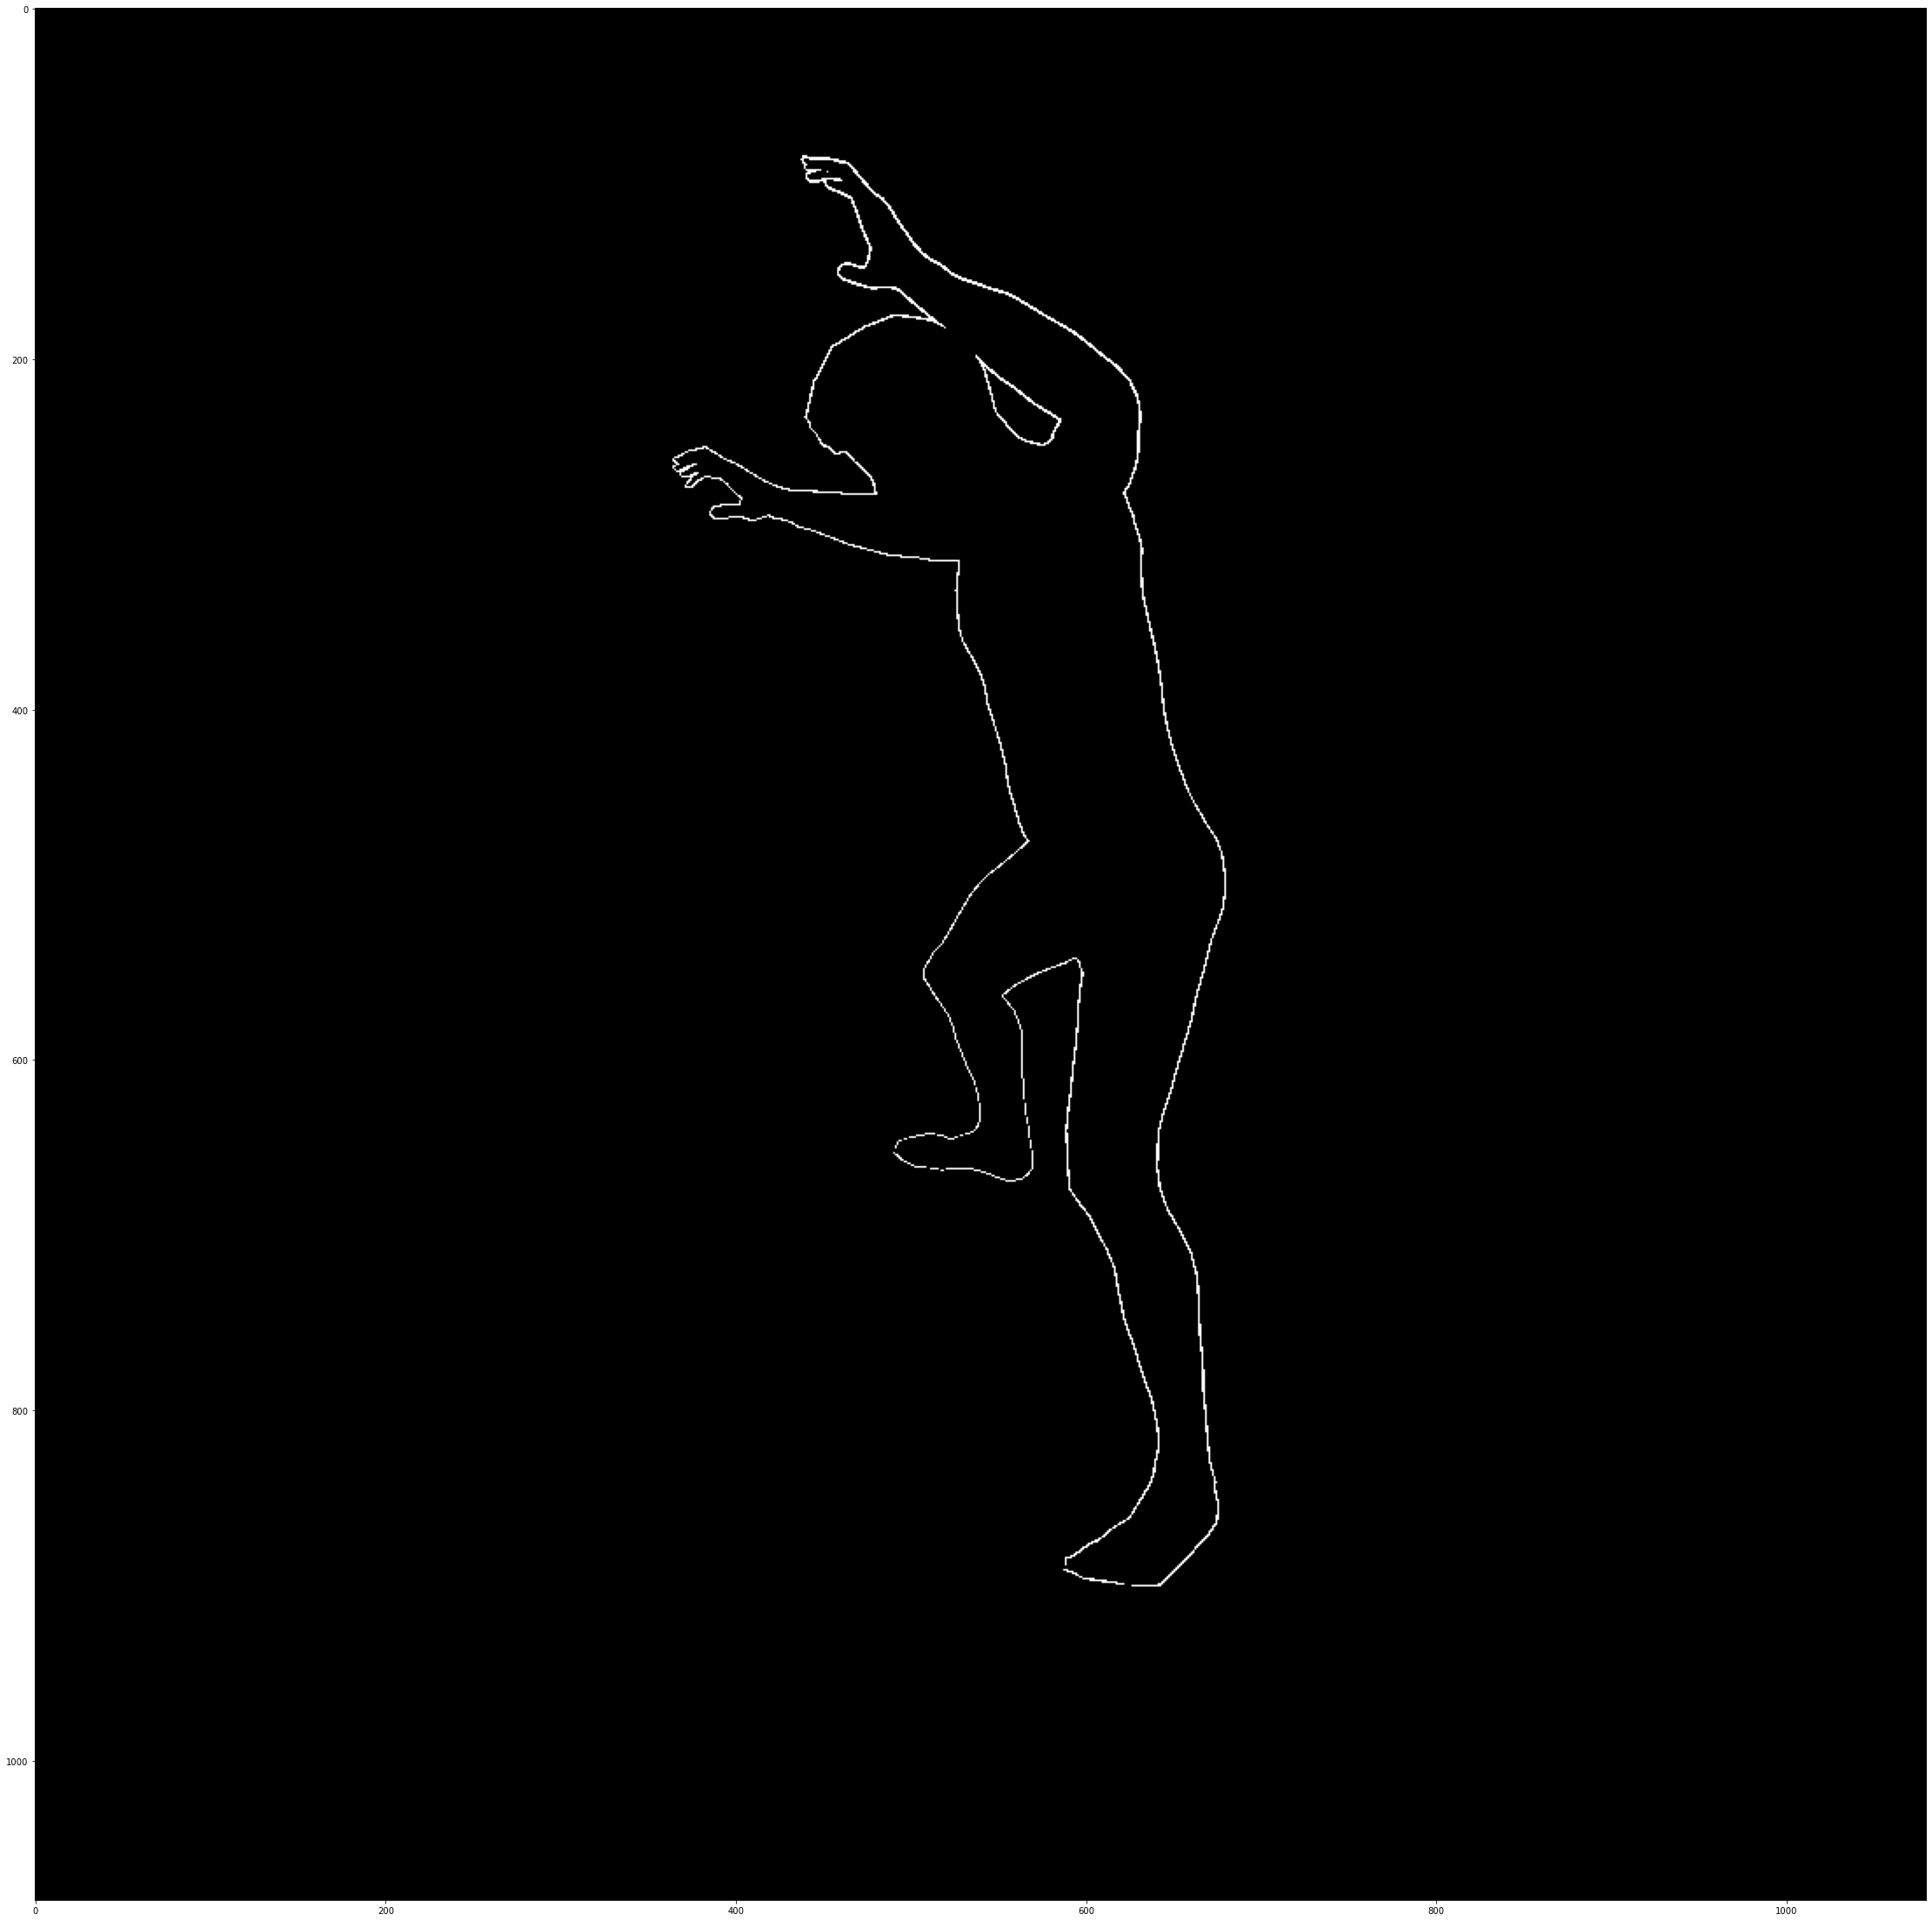

In [43]:
plt.figure(figsize=(40, 40))
plt.imshow(cv2.flip(contours[img_name][0], -1), cmap='gray')
plt.show()

In [44]:
class Model(nn.Module):
    def __init__(self, device, **kwargs):
        super().__init__()
        self.cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
        self.device = device
        self.image_size = kwargs.get('image_size', None)
        self.n_cams = len(self.cams)
        
        image_refs = kwargs.get('image_refs', None)
        self.image_refs = {}
            
        for img_name, img_list in image_refs.items():
            # (16, 1080, 1080, 1)
            imgs_torch = torch.from_numpy(np.array(img_list).astype(np.float32)).to(self.device)
            self.image_refs[img_name] = imgs_torch
            
        # set clean_plates: (16, 1080, 1080, 1)
        self.clean_plates = torch.from_numpy(np.zeros((self.n_cams, self.image_size, self.image_size)).astype(np.float32)).unsqueeze(-1).to(self.device)
        
        # load texturemaps: [0.0, 1.0] float
        texturemap_path = kwargs.get('texturemap_path', None)
        texturemap_shape = kwargs.get('texturemap_shape', None)
        if texturemap_path is not None:
            texturemap = cv2.imread(texturemap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
            texture_map_torch = torch.from_numpy(texturemap).unsqueeze(0).unsqueeze(-1)
        else:
            texture_map_torch = torch.from_numpy(np.zeros((1, texturemap_shape[0], texturemap_shape[1], 1)).astype(np.float32))
        self.texture_map = nn.Parameter(texture_map_torch.to(self.device), requires_grad=True)
        
        
        # batch_size
        self.batch_dict = {'img_name': [], 'cam_idx': [], 'mesh_idx': []}
        i = 0
        for img_name in self.image_refs.keys():
            for cam_idx in range(self.n_cams):
                self.batch_dict['img_name'].append(img_name)
                self.batch_dict['cam_idx'].append(cam_idx)
                self.batch_dict['mesh_idx'].append(i)
            i += 1
            
        # ====================
        # lights & renderers
        # ====================
        self.renderer = self._init_renderer()

        # camera batches
        self.cam_params = kwargs.get('cam_params', None)
        self.batch_size = kwargs.get('batch_size', None)
        self.n_batch = kwargs.get('n_batch', None)
        self.cam_batches = self._init_camera_batches(self.cam_params, batch_dict=self.batch_dict, n_batch=self.n_batch, batch_size=self.batch_size)
        
        # set mesh
        mesh_paths = kwargs.get('mesh_paths', None)
        self.meshes = self._load_meshes_list(self.device, mesh_paths=mesh_paths, texture_map=texture_map_torch.int())
        
        print('L2 loss')
    def forward(self, batch_idx, learn_texturemap: bool):
        losses = {'total': 0.0, 'pixel': 0.0}
        
        self.texture_map.requires_grad = learn_texturemap
        
        # ==================================================================================== #
        # minibatch training
        i0 = batch_idx*self.batch_size
        i1 = i0 + self.batch_size
        
        cam_indices = self.batch_dict['cam_idx'][i0:i1]
        mesh_indices = self.batch_dict['mesh_idx'][i0:i1]
        img_names = self.batch_dict['img_name'][i0:i1]

        cam_batch = self.cam_batches[batch_idx]
        meshes = [self.meshes[i] for i in mesh_indices]
        meshes = join_meshes_as_batch(meshes)
        image_cur = self.renderer(meshes_world=meshes, texture_maps=self.texture_map, cameras=cam_batch)

        # shape (batch_size, W, H)
        bgs = self.clean_plates[cam_indices].squeeze()
        
        # merge fg, bg, single channel
        image_cur_gray = self._merge_fg_bg(image_cur, bgs)
        # [0, 0.1] float32
        image_refs = torch.stack([self.image_refs[img_names[i]][cam_indices[i]] for i in range(self.batch_size)]).to(self.device)
        
#         l_reg = torch.mean(torch.where(self.texture_map < 0.0, self.texture_map**2, torch.zeros(self.texture_map.shape).to(self.device)))
#         l_reg += torch.mean(torch.where(self.texture_map > 1.0, (1.0-self.texture_map)**2, torch.zeros(self.texture_map.shape).to(self.device)))
        l_pixel = torch.mean((image_cur_gray - image_refs)**2)
#         l_pixel = torch.mean(torch.abs(image_cur_gray - image_refs))
        loss = l_pixel
        
#         losses['reg'] += l_reg
        losses['pixel'] += l_pixel.data
        losses['total'] += loss.data
        images_out = {'currents_with_bg': image_cur_gray, 'currents': image_cur, 'targets': image_refs}
        # ==================================================================================== #
        
        return images_out, loss, losses
    
    def _load_meshes_list(self, device, mesh_paths, texture_map):
        meshes_list = []
        for path in mesh_paths:
            verts, faces, aux = load_obj(path)
            faces_idx = faces.verts_idx

            verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
            faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
            textures = Textures(maps=texture_map, faces_uvs=faces_uvs, verts_uvs=verts_uvs)

            mesh = Meshes(
                verts=[verts.to(device)],   
                faces=[faces_idx.to(device)], 
                textures=textures.to(device)
            )

            meshes_list.append(mesh)
        return meshes_list
    
    def unit_spherical_to_cartesian(self, light_coords):
        """
        z-up, phi w.r.t. +z axis, theta w.r.t. +x axis
        """
        thetas = light_coords[0, :]
        phis = light_coords[1, :]
        radiuses = light_coords[2, :]
        
        r = radiuses * torch.sin(phis)
        z = radiuses * torch.cos(phis)
        x = r * torch.cos(thetas)
        y = r * torch.sin(thetas)
        
        xyz = torch.stack([x, y, z], dim=1)
        return xyz    
        
    def _merge_fg_bg(self, fg, bg):
        """
        fg: mesh rendering. [N, W, H, 4]: [0, 1.0] float
        bg: clean plate. [N, W, H, 1]: [0, 1.0] float
        out: [N, W, H, 4]
        """
        out = torch.where(fg[..., 3] > 0.0, fg[..., 0], bg)
        # out = torch.mul(1-fg[..., 3], bg)
        if len(out.shape) < 3:
            out = out.unsqueeze(0)
        return out

    def get_gpu_stats(self, output_str=True):
        mb_reserved = torch.cuda.memory_reserved() * 0.000001
        mb_alloc = torch.cuda.memory_allocated() * 0.000001
        mb_alloc_max = torch.cuda.max_memory_allocated() * 0.000001
        mb_cached = torch.cuda.memory_cached() * 0.000001
        mb_cached_max = torch.cuda.max_memory_cached() * 0.000001
        
        if output_str:
            return 'alloc={:,.0f}MB | cached={:,.0f}MB | reserved={:,.0f}MB'.format(mb_alloc, mb_cached, mb_reserved)
        else:
            return mb_alloc, mb_cached, mb_reserved
    
    def _load_mesh(self, device, mesh_path, texture_map):
        verts, faces, aux = load_obj(mesh_path)
        faces_idx = faces.verts_idx

        verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
        faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
        textures = Textures(maps=texture_map, faces_uvs=faces_uvs, verts_uvs=verts_uvs)

        mesh = Meshes(
            verts=[verts.to(device)],   
            faces=[faces_idx.to(device)], 
            textures=textures.to(device)
        )

        return mesh
    
    
    def _convert_mesh_into_batches(self, meshes):
        mesh_batches = []
        for batch_idx in range(self.n_batch):
            i0 = batch_idx*self.batch_size
            i1 = i0 + self.batch_size
            meshes_join = []
            for i in self.batch_dict['mesh_idx'][i0:i1]:
                meshes_join.append(meshes[i])
            mesh_batch = join_meshes(meshes_join, include_textures=True)
            mesh_batches.append(mesh_batch)
        return mesh_batches
    
    def save_parameters(self, out_path):
        deform_verts = self.deform_verts.detach().cpu().numpy()
        np.save(out_path, deform_verts)
        print('Parameters saved:', out_path)
        
    def load_parameters(self, in_path):
        self.deform_verts = nn.Parameter(torch.from_numpy(np.load(in_path)).to(self.device))
        print('Parameters loaded: {}'.format(self.deform_verts.shape))
        
    def export_obj(self, out_dir, vt_path=None, fname_suffix=''):
        vt_lines = []
        f_lines = []
        if vt_path is not None:
            with open(vt_path, 'r') as f:
                lines = f.readlines()
                for l in lines:
                    v = l.split(' ')
                    if v[0] == 'vt':
                        vt_lines.append(l)
                    elif v[0] == 'f':
                        f_lines.append(l)

        # normal_deforms = self.deform_verts * self.vert_normals
        dverts = self.deform_verts
        
        out_name = 'learned_mesh'
        for mesh_idx in range(len(self.meshes)):
            out_path = out_dir + '/{}_{}{}.obj'.format(out_name, mesh_idx, fname_suffix)
            deformed_mesh = self.meshes[mesh_idx].offset_verts(dverts)

            verts = deformed_mesh.verts_packed()
            faces = deformed_mesh.faces_packed()
            vnormals = deformed_mesh.verts_normals_list()[0]
            fnormals = deformed_mesh.faces_normals_list()[0]

            assert(faces.shape[0] == fnormals.shape[0])
            assert(vnormals.shape[0] == verts.shape[0])

            with open(out_path, 'w+') as f:
                f.write('# OBJ file created by Hyojoon Park.\n')
                f.write('###########################\n')
                f.write('# Vertices:       {}\n'.format(verts.shape[0]))
                f.write('# Vertex normals: {}\n'.format(vnormals.shape[0]))
                f.write('# Faces:          {}\n'.format(faces.shape[0]))
                f.write('###########################\n')
                f.write('mtllib learned_mesh.mtl\n')
                for i in range(verts.shape[0]):
                    f.write('vn {} {} {}\n'.format(vnormals[i][0], vnormals[i][1], vnormals[i][2]))
                    f.write('v {} {} {}\n'.format(verts[i][0], verts[i][1], verts[i][2]))
                    
                for vtl in vt_lines:
                    f.write(vtl)
                    
                if len(f_lines) > 0:
                    for fl in f_lines:
                        f.write(fl)
                else:
                    for i in range(faces.shape[0]):
                        f.write("f")
                        face = faces[i, :]
                        for fi in range(face.shape[0]):
                            f.write(' {0:.0f}//{0:.0f}//{0:.0f}'.format(face[fi] + 1, fnormals[fi] + 1))
        #                     f.write(' {0:.0f}'.format(face[fi]))
                        f.write("\n")

            print('[{}/{}] Obj exported to: {}'.format(mesh_idx+1, len(self.meshes), out_path))
        
    def _init_renderer(self):
        self.n_lights = 1
        xyz = np.float32([0, 0, 3000])
        # fixed light brightness
        diffuse = 0.0
        ambient = 0.5
        specular = 0.0
        s = specular*torch.from_numpy(np.ones((1, 3)).astype(np.float32)).to(self.device)
        d = diffuse *torch.from_numpy(np.ones((1, 3)).astype(np.float32)).to(self.device)
        a = ambient *torch.from_numpy(np.ones((1, 3)).astype(np.float32)).to(self.device)
        light = PointLights(device=self.device, location=xyz, specular_color=s, ambient_color=a, diffuse_color=d)
        light.specular_color = s
        light.diffuse_color = d
        light.ambient_color = a
        shader = TexturedSoftPhongShader(
                    device=self.device, 
                    cameras=None,
                    lights=light,
                    blend_params=BlendParams(sigma=1e-4, gamma=1e-4)
                )
        
        raster_settings = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0, 
            faces_per_pixel=1, 
            bin_size = 0, # this setting controls whether naive or coarse-to-fine rasterization is used
            max_faces_per_bin = None  # this setting is for coarse rasterization
        )
        
        renderer = MeshRenderer(
                rasterizer=MeshRasterizer(
                    cameras=None,
                    raster_settings=raster_settings
                ),
                shader=shader
            )
        
        return renderer
    
    def _init_camera(self, cam_torch):
        R = cam_torch['R']
        T = cam_torch['T']
        focal_length = cam_torch['fl']
        principal_point = cam_torch['pp']
        cameras = SfMPerspectiveCameras(device=self.device, R=R, T=T, principal_point=principal_point, focal_length=focal_length)
        return cameras

    def _init_camera_batches(self, cam_torch, batch_dict, n_batch, batch_size):
        cams = []
        for batch_idx in range(n_batch):
            i0 = batch_idx*batch_size
            i1 = i0 + batch_size
            cam_indices = batch_dict['cam_idx'][i0:i1]
            R = cam_torch['R'][cam_indices]
            T = cam_torch['T'][cam_indices]
            focal_length = cam_torch['fl'][cam_indices]
            principal_point = cam_torch['pp'][cam_indices]
            cameras = SfMPerspectiveCameras(device=self.device, R=R, T=T, principal_point=principal_point, focal_length=focal_length)
            cams.append(cameras)
        return cams
    
batch_size = 2
n_batch = n_forwards // batch_size
# texturemap_path = './9_data/output/200413_SingleVsMulti/multi_L1/texturemap_learned.png'
texturemap_path = None
model = Model(device, img_dir=img_dir, texturemap_path=texturemap_path, texturemap_shape=texturemap_shape, cam_params=cams_torch, image_refs=contours, mesh_paths=mesh_paths, image_size=image_size, batch_size=batch_size, n_batch=n_batch)


L2 loss


In [27]:
print(contours['03052'].shape)

(16, 1080, 1080)


## check target images, clean plates

In [103]:
%matplotlib inline
img_name = '03052'
cam_idx = 0
img1 = img_refs_undistorted[img_name][cam_idx]
print(img_refs[img_name].keys())
img2 = img_refs[img_name][cam_idx]
print('Image original =========')
print(' ', img1.shape, ',', np.max(img1), ',', img1.dtype)
print('   {:,.2f} Mb'.format(img1.nbytes * 0.000001))
print('Image cropped =========')
print(' ', img2.shape, ',', np.max(img2), ',', img2.dtype)
print('   {:,.2f} Mb'.format(img2.size * img2.itemsize * 0.000001))
print()

# overlay ref image & cropped ref image
for img_name in img_names:
    for i in range(16):
        # target image
        img1 = img_refs_undistorted[img_name][i]
        img2 = np.zeros((img1.shape[0], img1.shape[1]))
        cx = img2.shape[0] // 2
        cy = img2.shape[1] // 2
        imgref = cv2.flip(cv2.resize(img_refs[img_name][i], (img1.shape[0], img1.shape[0])), -1)
        w = imgref.shape[0] // 2
        h = imgref.shape[0] // 2 
        img2[cx-w:cx+w,cy-h:cy+h] = imgref
        
        cp = cv2.flip(cv2.resize(clean_plates[i], (img1.shape[0], img1.shape[0])), -1)
        img2[cx-w:cx+w,cy-h:cy+h] = cp
        
        plt.figure(figsize=(15, 15))
        plt.imshow(img1, cmap='gray', alpha=0.5)
        plt.imshow(img2, cmap='gray', alpha=0.5)
        break

for i in range(16):
    # clean plates
    img1 = clean_plates_undistort[i]
    img2 = clean_plates[i]
    fig, ax = plt.subplots(1, 2, figsize=(50, 50))
    ax[0].imshow(img1, cmap='gray')
    ax[0].set_title('undistorted')
    ax[1].imshow(img2, cmap='gray')
    ax[1].set_title('undistorted & cropped')
    ax[1].invert_yaxis()
    ax[1].invert_xaxis()
    plt.show()
    break

dict_keys(['03052'])


KeyError: 0

# Model

In [ ]:
img_refs.keys()

In [16]:
def render_4(save_dir, i, img_name, cam_idx, img1, img2, img3):
    fig, ax = plt.subplots(1, 4, figsize=(20, 6), tight_layout=True)
    ax = ax.ravel()
    ax[0].imshow(img1, cmap='gray')
    ax[0].set_title('{}. {}.pgm, cam[{}/{}]\nTarget'.format(i, img_name, cam_idx+1, len(cams)))
    ax[0].set_xlabel('{}, [{:.2f}, {:.2f}]'.format(img1.shape, np.min(img1), np.max(img1)))
    
    ax[1].imshow(img2, cmap='gray', vmin=0)
    ax[1].set_xlabel('{}, [{:.2f}, {:.2f}]'.format(img2.shape, np.min(img2), np.max(img2)))
    ax[1].set_title('Rendered')
    
    ax[2].imshow(img1, cmap='gray')
    img3 = np.dstack([img3, np.zeros(img3.shape), np.zeros(img3.shape)])
    ax[2].imshow(img3, alpha=0.45)
    ax[2].set_title('Overlay')
    ax[2].set_xlabel('{}, [{:.2f}, {:.2f}]'.format(img3.shape, np.min(img3), np.max(img3)))

    diff = img2 - img1
    diff_normalized = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))
    ax[3].set_title('Difference')
    ax[3].set_xlabel('{}, [{:.2f}, {:.2f}]'.format(diff.shape, np.min(diff), np.max(diff)))
    ax[3].imshow(diff_normalized)

    #plt.show()
    save_path = out_dir + '/initial_mesh_{}_cam{}'.format(img_name, cam_idx)
    plt.savefig(save_path, dpi=300)
    plt.close('all')
    
    print('  saved:', save_path)
    
    
texturemap_path = None
n = 0
for img_idx, img_name in enumerate(img_names):
    for cam_idx in range(16):
        mesh_path = mesh_paths[img_idx]
        clean_plate = clean_plates[cam_idx]
        cam_torch = {}
        for k, v in cams_torch.items():
            cam_torch[k] = v[cam_idx].unsqueeze(0)
        image_ref = img_refs[img_name][cam_idx]
        model = Model(cam_indices=[cam_idx], device=device, img_dir=img_dir, texturemap_path=texturemap_path, texturemap_shape=texturemap_shape, cam_params=cam_torch, image_ref=image_ref, mesh_path=mesh_path, image_size=image_size, clean_plate=clean_plate)
        
        
        # forward
        images_with_bg = np.empty((n_batch*batch_size, model.image_size, model.image_size))
        images = np.empty((n_batch*batch_size, model.image_size, model.image_size, 4))
        images_target = np.empty((n_batch*batch_size, model.image_size, model.image_size))
        losses = []
        print('{} renders ({} images, {} cams), n_batch={}, batch_size={}'.format(n_forwards, len(img_names), len(cams), n_batch, batch_size))
        for batch_idx in range(n_batch):
            i0 = batch_idx*batch_size
            i1 = i0 + batch_size

            imgs, l, l_dict = model(learn_texturemap=False)
            losses.append(l.detach().cpu().data)

            images_with_bg[i0:i1] = imgs['currents_with_bg'].detach().cpu().numpy()
            images[i0:i1] = imgs['currents'].detach().cpu().numpy()
            images_target[i0:i1] = imgs['targets'].detach().cpu().numpy()

            img1 = cv2.flip(images_target[batch_idx].squeeze(), -1)
            img2 = cv2.flip(images_with_bg[batch_idx].squeeze(), -1)
            img3 = cv2.flip(images[batch_idx].squeeze(), -1)[..., 3]
            
            out_dir = './14g_data/output'
            render_4(out_dir, n, img_name, cam_idx, img1, img2, img3)
            n += 1
            break
        break
print('-------- Done. n=', n)

NameError: name 'clean_plates' is not defined

### test run

In [127]:
images_with_bg = np.empty((n_batch*batch_size, model.image_size, model.image_size))
images = np.empty((n_batch*batch_size, model.image_size, model.image_size, 4))
images_target = np.empty((n_batch*batch_size, model.image_size, model.image_size))
losses = []
print('{} renders ({} images, {} cams), n_batch={}, batch_size={}'.format(n_forwards, len(img_names), len(cams), n_batch, batch_size))
for batch_idx in range(n_batch):
    print(batch_idx)
    i0 = batch_idx*batch_size
    i1 = i0 + batch_size
    
    imgs, l, l_dict = model(batch_idx=batch_idx, learn_texturemap=False)
    losses.append(l.detach().cpu().data)

    images_with_bg[i0:i1] = imgs['currents_with_bg'].detach().cpu().numpy()
    images[i0:i1] = imgs['currents'].detach().cpu().numpy()
    images_target[i0:i1] = imgs['targets'].detach().cpu().numpy()
    # model.save_parameters('./7_data/output/deform_verts.npy')
    # model.export_obj('./7_data/output/obj.obj')


16 renders (1 images, 16 cams), n_batch=8, batch_size=2
0
1
2
3
4
5
6
7


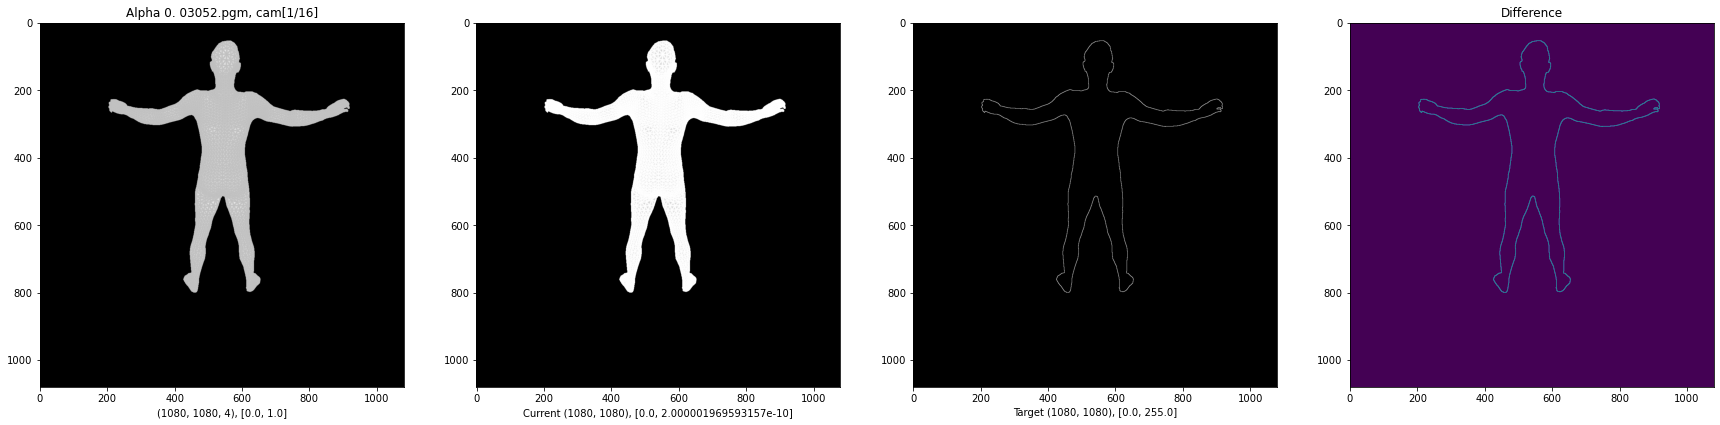

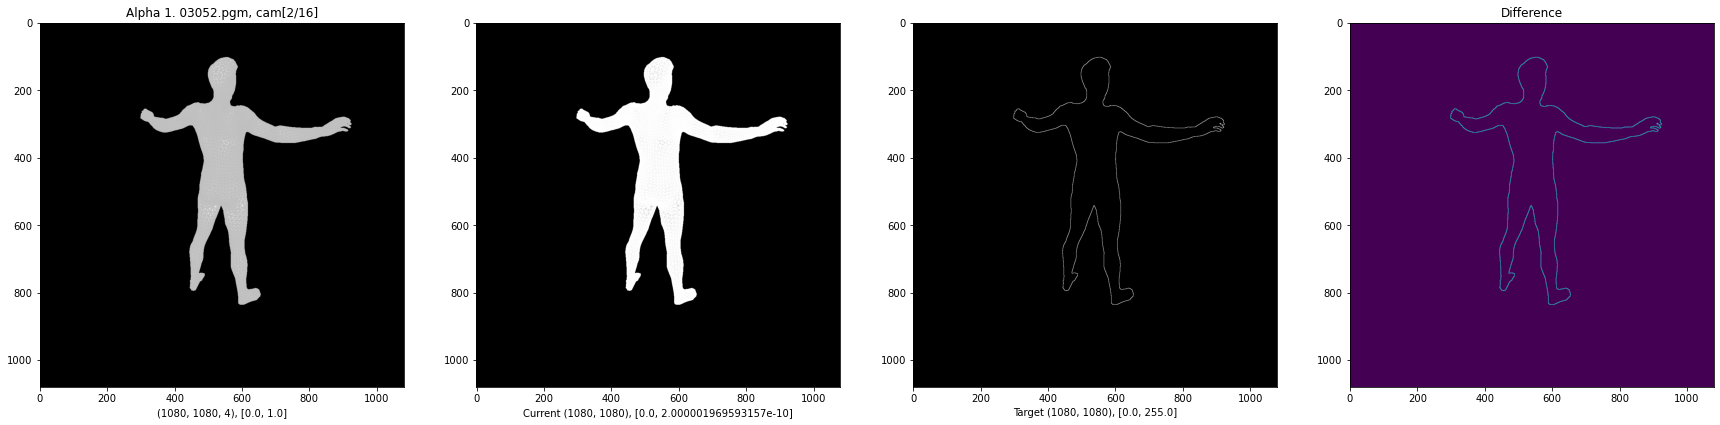

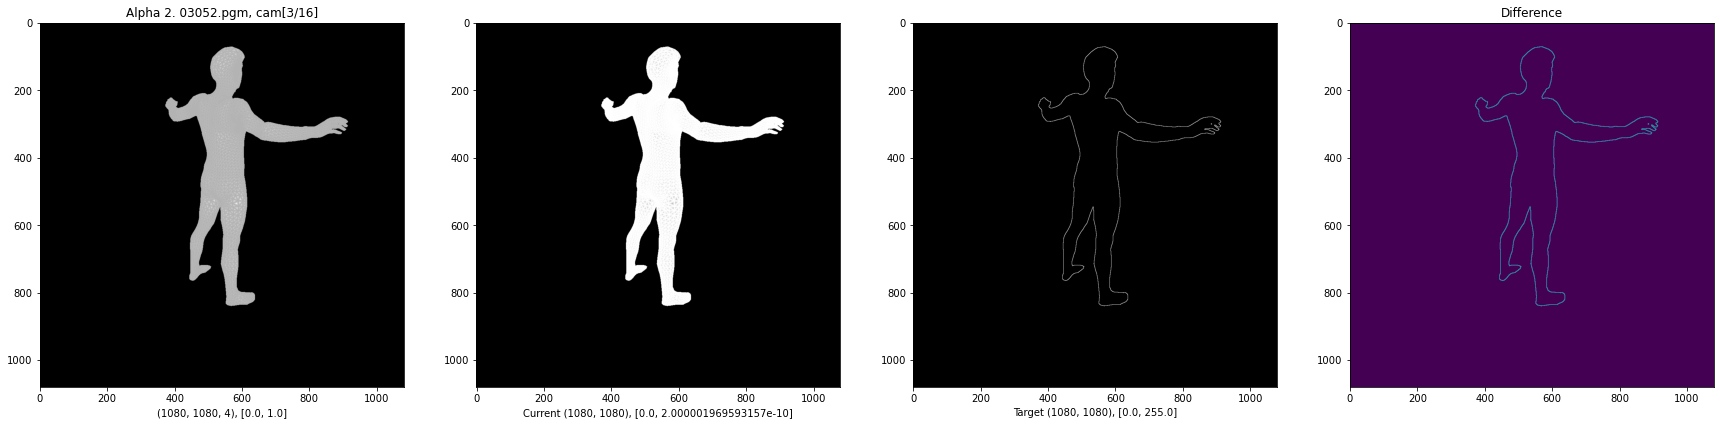

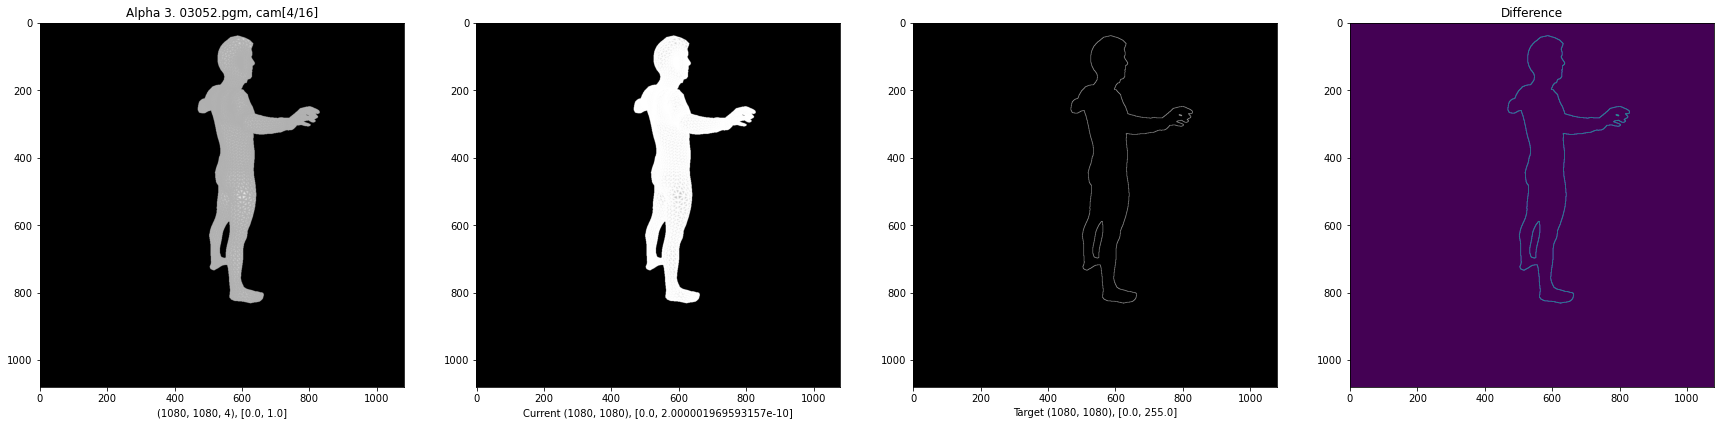

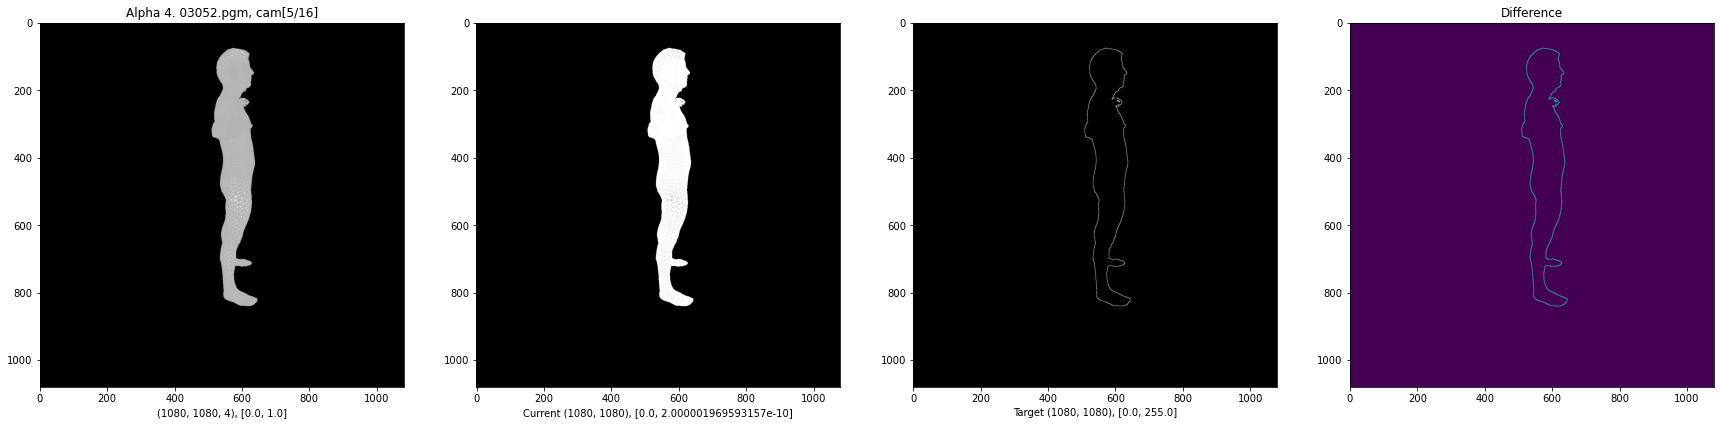

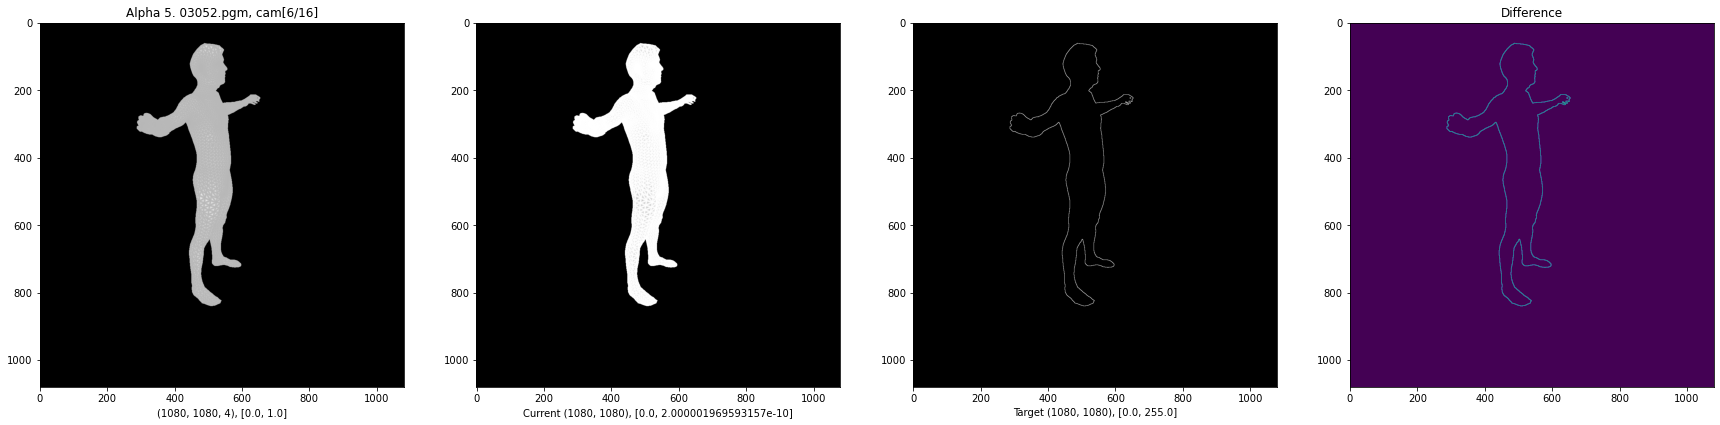

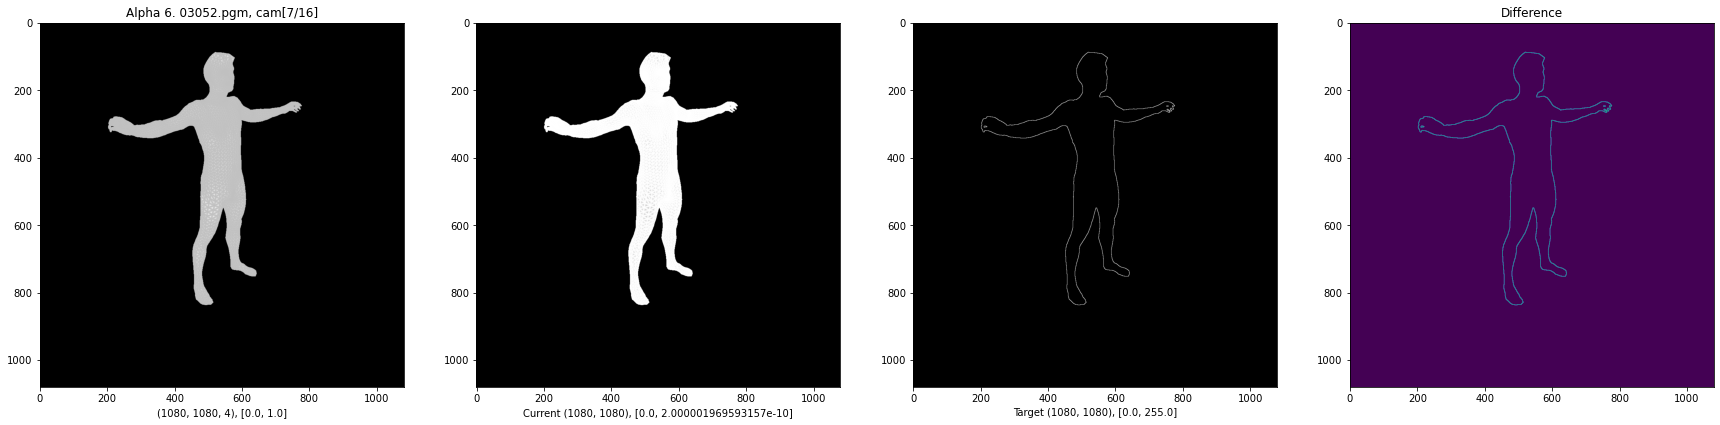

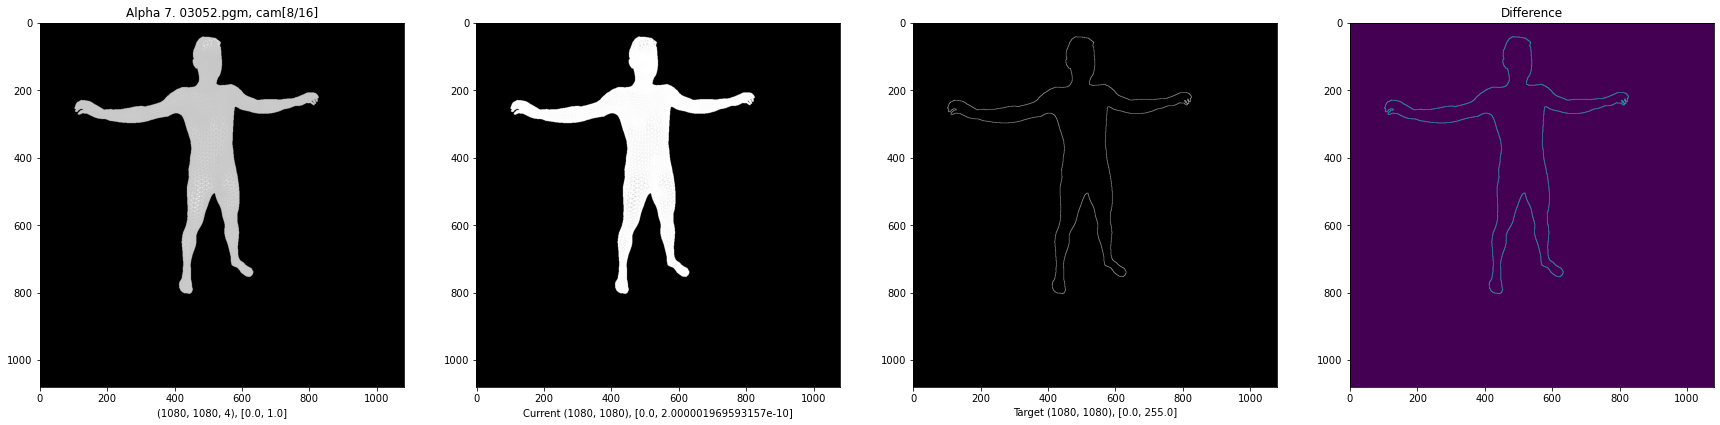

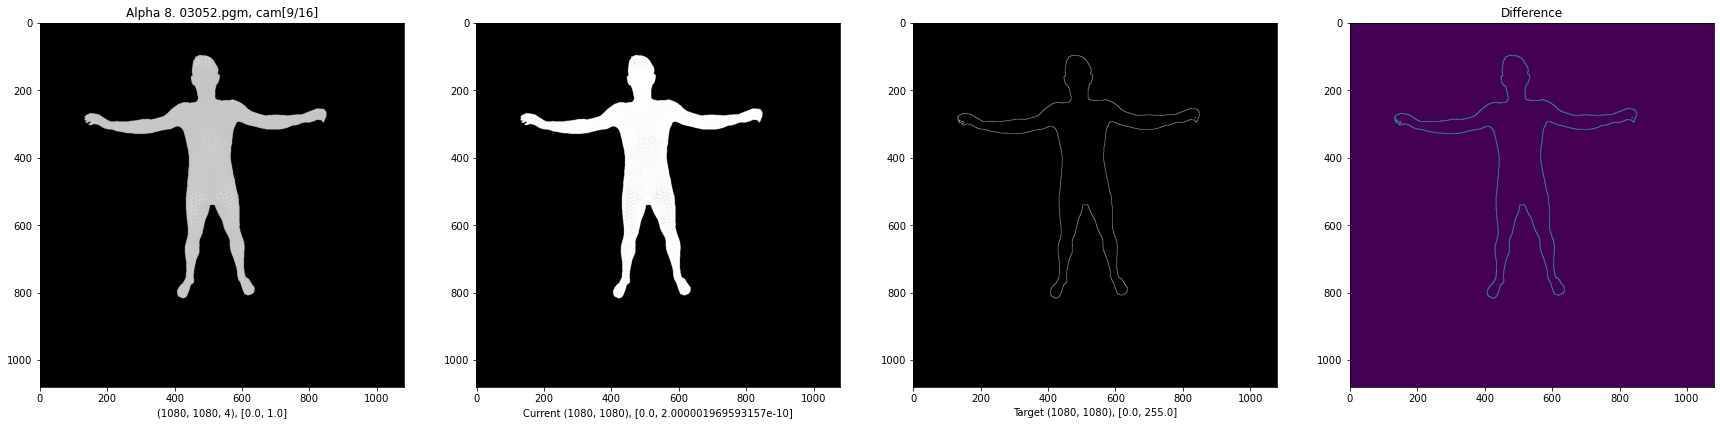

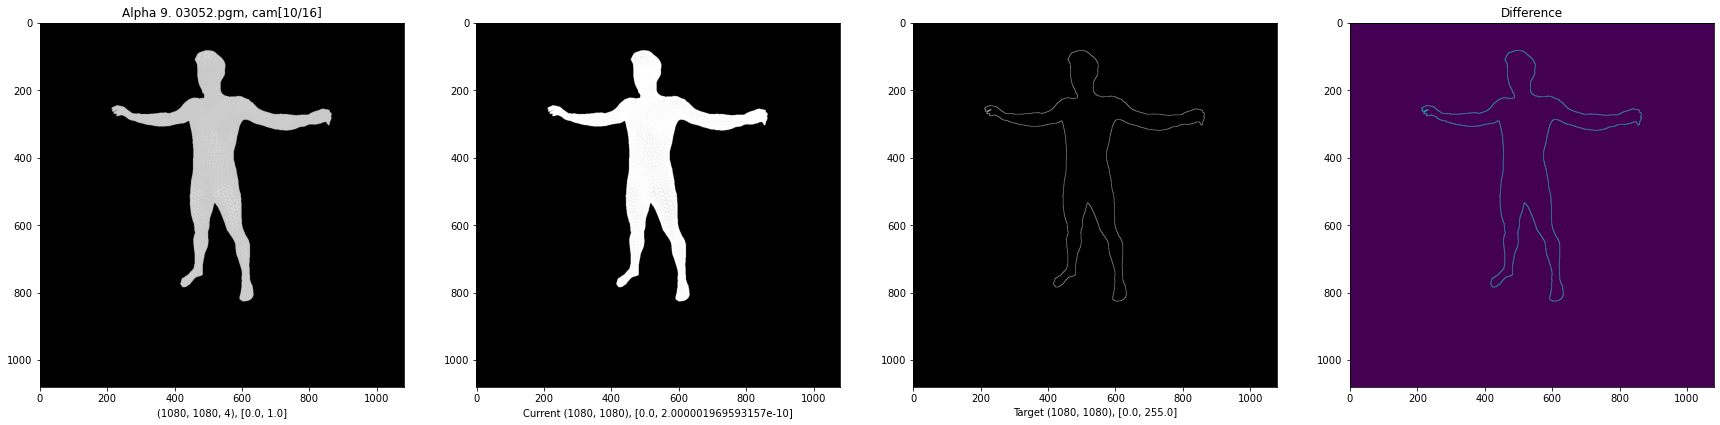

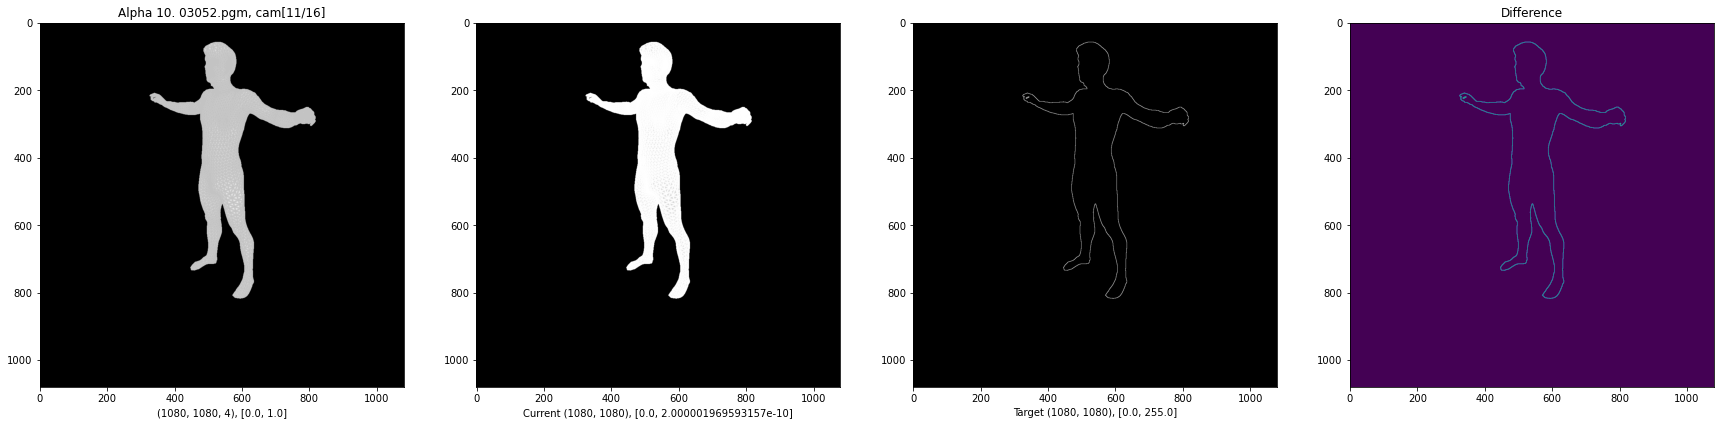

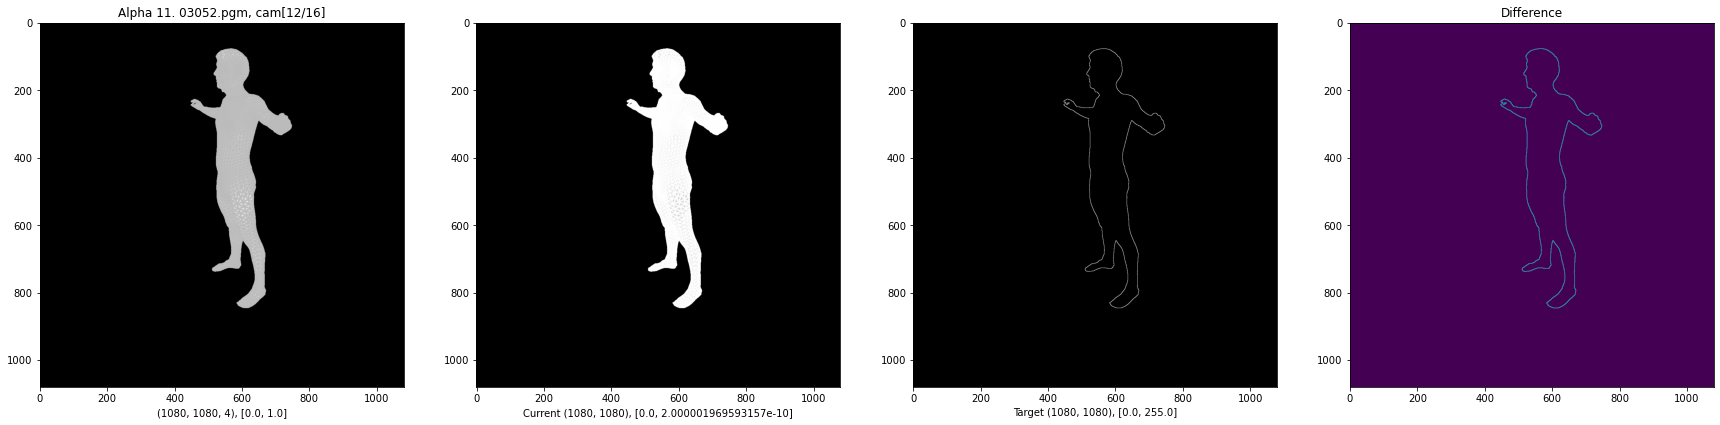

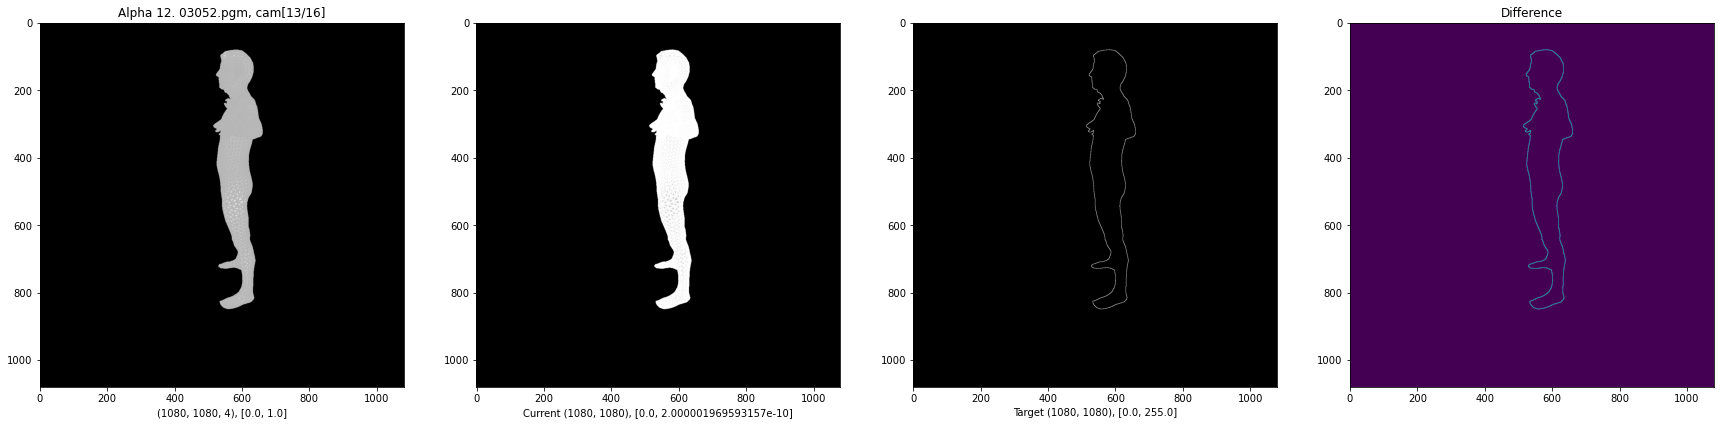

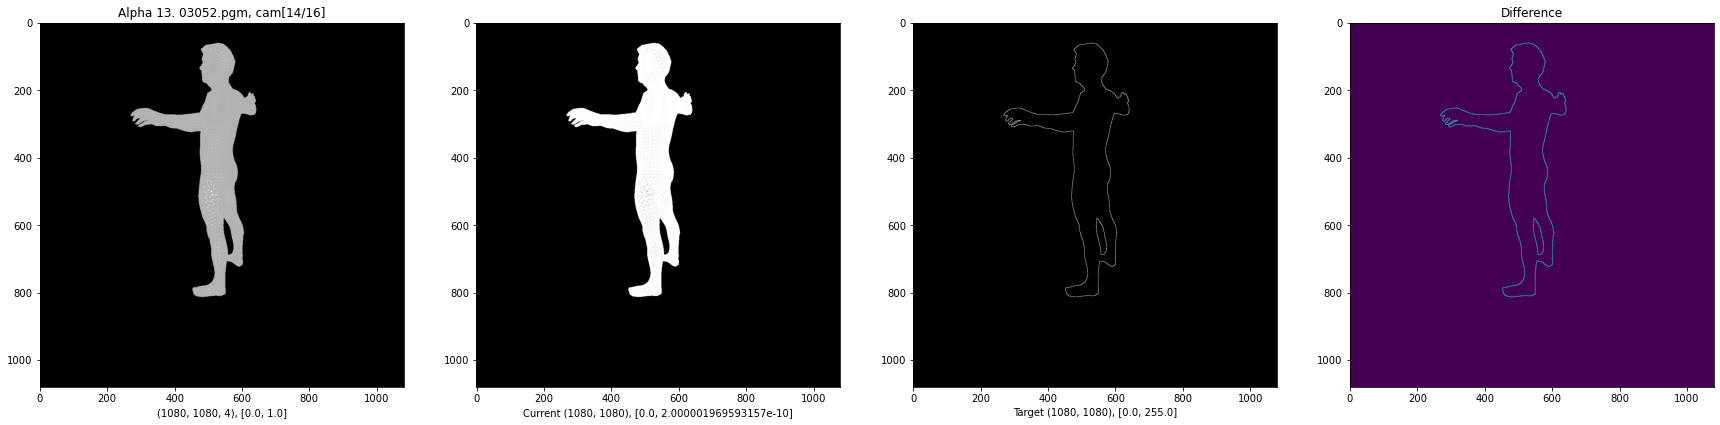

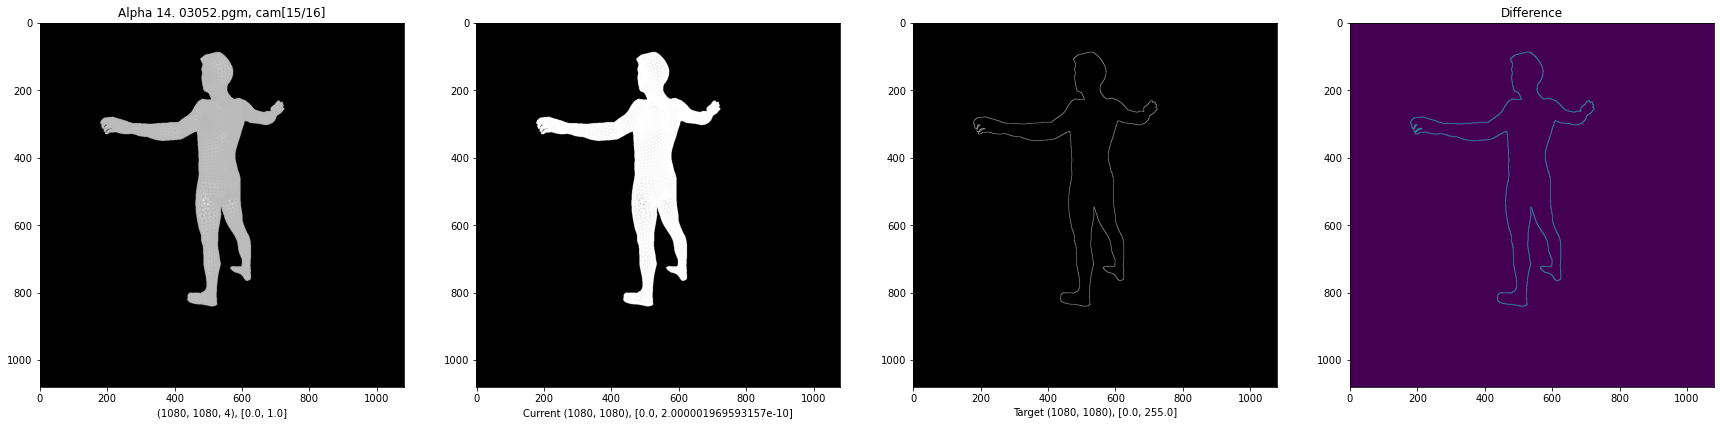

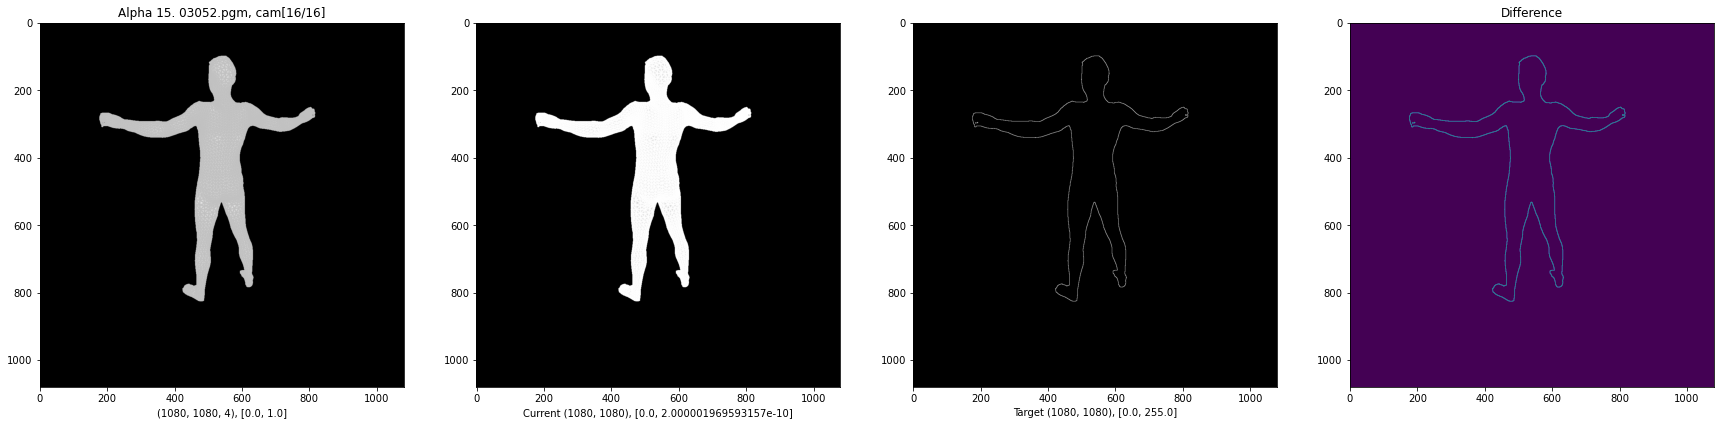

In [128]:
for img_idx in range(len(img_names)):
    for cam_idx in range(len(cams)):
        i = img_idx*len(cams) + cam_idx
        fig, ax = plt.subplots(1, 4, figsize=(30, 10))
        ax = ax.ravel()
        img = cv2.flip(images[i], -1)
        ax[0].imshow(img[..., 3], cmap='gray')
        ax[0].set_title('Alpha {}. {}.pgm, cam[{}/{}]'.format(i, img_names[img_idx], cam_idx+1, len(cams)))
        ax[0].set_xlabel('{}, [{}, {}]'.format(img.shape, np.min(img), np.max(img)))

        img = cv2.flip(images_with_bg[i], -1)
        ax[1].imshow(img, cmap='gray')
        ax[1].set_xlabel('Current {}, [{}, {}]'.format(img.shape, np.min(img), np.max(img)))

        img2 = cv2.flip(images_target[i], -1)
        ax[2].imshow(img2, cmap='gray')
        ax[2].set_xlabel('Target {}, [{}, {}]'.format(img2.shape, np.min(img2), np.max(img2)))

        diff = np.abs(img2 - img)
        ax[3].imshow(diff)
        ax[3].set_title("Difference")


# reprojection check

In [ ]:
mesh_points = {}

t0 = time.time()
for i in range(len(model.mesh)):
    mesh_vertices = model.mesh[i].verts_packed().cpu()
    
    pts = []
    for cam_idx in range(16):
        params = cam_params[cam_idx]
        p = reproject(params, mesh_vertices, distort=False)
        pts.append(p)
    
    img_name = img_names[i]
    mesh_points[img_name] = pts
t1 = time.time()
print('{:.2f}s'.format(t1-t0))
print(len(mesh_points))
del mesh_vertices, pts

In [ ]:
for k, v in mesh_points.items():
    print(k, ':', len(v), 'cameras,', v[0].shape, 'points/camera')

In [ ]:
%matplotlib inline

for mesh_idx, img_name in enumerate(list(mesh_points.keys())):
    print(img_name)
    
    for cam_idx in range(model.n_cams):
        i = mesh_idx*model.n_cams + cam_idx
        
        plt.figure(figsize=(10, 10))
        
        # bg
        img_bg = img_refs[img_name][cam_idx]
        img_bg = cv2.flip(img_bg, -1)
        plt.imshow(img_bg, alpha=0.5, cmap='gray')

        # mesh from pytorch3d
        img_mesh = images[i]
        img_mesh = cv2.flip(img_mesh, -1)
        plt.imshow(img_mesh, alpha=0.5, cmap='gray')

        pts = mesh_points[img_name][cam_idx]
        pts_small_x = (pts[:, 0] - (4000-2160)*0.5) * image_size/2160
        pts_small_y = pts[:, 1] * image_size/2160
        pts_small = np.stack([pts_small_x, pts_small_y]).T
        pts_center = np.mean(pts_small, axis=0)
        plt.scatter(pts_small[:, 0], pts_small[:, 1], c='b', s=0.1)
        plt.title('Camera {}'.format(i))

        # plot centers
        plt.scatter(pts_center[0], pts_center[1], c='r')

#         if i == 0:
#             print('reference image:', np.max(img_bg), img_bg.dtype, img_bg.shape)
#             print('rendered pytorch image :', np.max(img_mesh), img_mesh.dtype, img_mesh.shape, ', {:,.2f} Mb'.format(img_mesh.nbytes * 0.000001), np.max(img_mesh))
#         plt.show()

# before training

### test plot

In [17]:
def plot_6(out_dir, e, batch_idx, lr, img_name, cam_idx, loss_dict, grads, image_curr, image_target, texturemap):
    fig, ax = plt.subplots(1, 6, figsize=(30, 6), tight_layout=True)
    plt.suptitle('Epoch {} | {}.pgm | lr={}'.format(e, img_name, lr), fontsize=16)
    a_loss = ax[0]
    a_grad = ax[1]
    a_curr = ax[2]
    a_target = ax[3]
    a_diff = ax[4]
    a_tex = ax[5]
    
    losses = loss_dict['total']
    legends = []
    a_loss.plot(losses, linewidth=3)
    for k, v in loss_dict.items():
        legends.append(k)
        if k != 'total':
            a_loss.plot(v)
    a_loss.set_title('losses: {}'.format(losses[-1]))
    a_loss.legend(legends)
    a_loss.grid()
    
    a_grad.set_title('||grad||')
    a_grad.grid()
    
    a_curr.imshow(image_curr, cmap='gray', vmin=0, vmax=1.0)
    a_curr.set_title('current | camera {}'.format(cam_idx))
    a_curr.set_xlabel('{}'.format(image_curr.shape))
    
    a_target.imshow(image_target, cmap='gray', vmin=0, vmax=1.0)
    a_target.set_title('target')
    a_target.set_xlabel('{}'.format(image_target.shape))
    
    diff = image_curr - image_target
    diff_abs = np.abs(diff)
    a_diff.imshow(diff_abs)
    a_diff.set_title('difference')
    a_diff.set_xlabel('{}, min={:.2f}, max={:.2f}'.format(diff.shape, np.min(diff), np.max(diff)))
    
    a_tex.imshow(np.clip(texturemap, a_min=0, a_max=1.0), cmap='gray', vmin=0, vmax=1.0)
    a_tex.set_title('texturemap')
    a_tex.set_xlabel('{}, min={:.2f}, max={:.2f}'.format(texturemap.shape, np.min(texturemap), np.max(texturemap)))
    
    out_path = out_dir + '/plot_{}.png'.format(e)
    plt.savefig(out_path, dpi=300)
    plt.close()
    
    plot_img = imageio.imread(out_path)
    return plot_img

def plot_3(out_dir, i, N, img_name, cam_idx, image_curr, image_target):
    fig, ax = plt.subplots(1, 3, figsize=(18, 7), tight_layout=True)
    plt.suptitle('[{}/{}] {}.pgm'.format(i+1, N, e, img_name), fontsize=16)
    a_curr = ax[0]
    a_target = ax[1]
    a_diff = ax[2]
    
    a_curr.imshow(image_curr, cmap='gray', vmin=0, vmax=1.0)
    a_curr.set_title('current | camera {}'.format(cam_idx))
    a_curr.set_xlabel('{}'.format(image_curr.shape))
    
    a_target.imshow(image_target, cmap='gray', vmin=0, vmax=1.0)
    a_target.set_title('target')
    a_target.set_xlabel('{}'.format(image_target.shape))
    
    diff = image_curr - image_target
    diff_abs = np.abs(diff)
    a_diff.imshow(diff_abs)
    a_diff.set_title('difference')
    a_diff.set_xlabel('{}, min={:.2f}, max={:.2f}'.format(diff.shape, np.min(diff), np.max(diff)))
    
    out_path = out_dir + '/plot_final_{}.png'.format(i)
    plt.savefig(out_path, dpi=300)
    plt.close()
    
    plot_img = imageio.imread(out_path)
    return plot_img

### test forward, backward & plot

In [47]:
# =================================================================================== #
batch_size = 2
n_batch = n_forwards // batch_size
model = Model(device, texturemap_path=None, texturemap_shape=texturemap_shape, img_dir=img_dir, cam_params=cams_torch, image_refs=img_refs, mesh_paths=mesh_paths, image_size=image_size, clean_plates=clean_plates, batch_size=batch_size, n_batch=n_batch)

print('----- torch.cuda.empty_cache() -----')
torch.cuda.empty_cache()
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))
# =================================================================================== #

out_dir = './21_data/output'

lr = 1.0
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


print('{} renders ({} images, {} cams), n_batch={}, batch_size={}'.format(n_forwards, len(img_names), len(cams), n_batch, batch_size))
plot_idx = 0
e = 0
losses = {'total': [0, 0.1], 'pixel': [0, 0.2]}
for batch_idx in range(2, n_batch):
    print(batch_idx)
    i0 = batch_idx*batch_size
    i1 = i0 + batch_size
    img_name = model.batch_dict['img_name'][i0:i1][plot_idx]
    cam_idx = model.batch_dict['cam_idx'][i0:i1][plot_idx]
    
    # ================== #
    # train
    # ================== #
    optimizer.zero_grad()
    imgs, l, l_dict = model(batch_idx, learn_texturemap=True)
    l.backward()
    optimizer.step()
    
    grads = None
    img_curr = cv2.flip(imgs['currents_with_bg'][plot_idx].detach().squeeze().cpu().numpy(), -1)
    img_target = cv2.flip(imgs['targets'][plot_idx].detach().squeeze().cpu().numpy(), -1)
    losses['total'].append(l_dict['total'].detach().cpu().numpy())
    losses['pixel'].append(l_dict['pixel'].detach().cpu().numpy())
    texturemap = model.texture_map.clone().detach().squeeze().cpu().numpy()
    plot_img = plot_6(out_dir, e, batch_idx, img_name, cam_idx, losses, grads, img_curr, img_target, texturemap)
    plt.figure(figsize=(30, 6))
    plt.imshow(plot_img)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    break


----- torch.cuda.empty_cache() -----
torch.cuda.memory_allocated(): 241.45 Mb
torch.cuda.memory_cached(): 664.80 Mb
16 renders (1 images, 16 cams), n_batch=8, batch_size=2
2


TypeError: plot_6() missing 1 required positional argument: 'texturemap'

# === Train ===

In [18]:
def get_settings_str(img_names):
    log_str = ''
    
    log_str += '{:<15}: {}\n'.format('cameras', cam_path)
    log_str += '{:<15}: {}\n'.format('mesh', mesh_dir)
    log_str += '{:<15}: {}\n'.format('clean plates', clean_plate_dir)
    log_str += '{:<15}:'.format('images')
    for img_name in img_names:
        log_str += ' {}.pgm'.format(img_name)
    log_str += '\n'
    log_str += '---------------------------------------------\n\n'
    return log_str

In [25]:
img_names

['03052']

L2 loss
----- torch.cuda.empty_cache() -----
torch.cuda.memory_allocated(): 535.75 Mb
torch.cuda.memory_cached(): 713.03 Mb
Log output: ./22_data/output/log_20200618.txt


<ipython-input-45-1485f1c90eae>:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(1000000000))


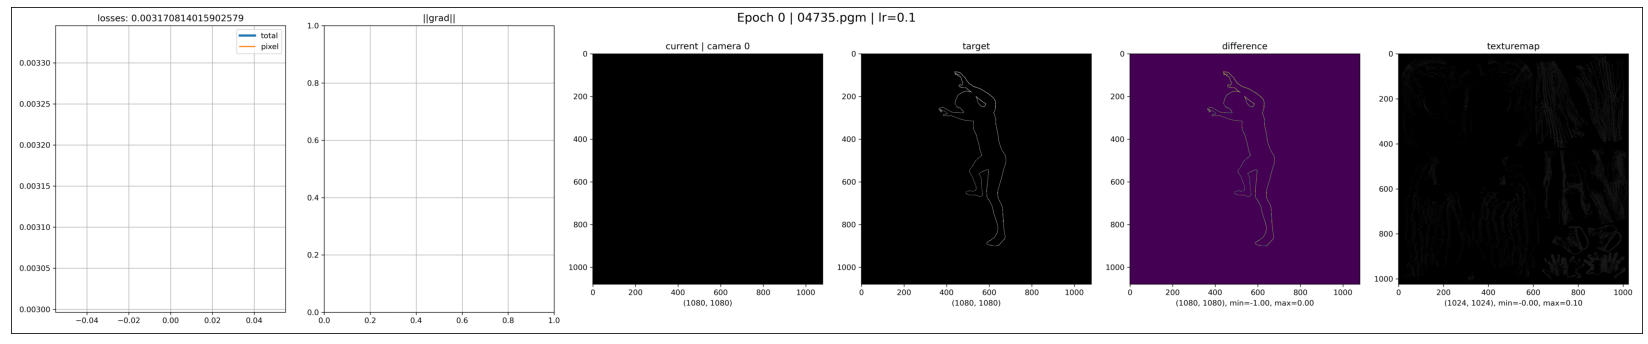

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\hjoon\AppData\Local\Continuum\anaconda3\envs\pytorch3d\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-1485f1c90eae>", line 58, in <module>
    imgs, l, l_dict = model(batch_idx, learn_texturemap=True)
  File "C:\Users\hjoon\AppData\Local\Continuum\anaconda3\envs\pytorch3d\lib\site-packages\torch\nn\modules\module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-44-d0f0f3d696d8>", line 74, in forward
    image_cur = self.renderer(meshes_world=meshes, texture_maps=self.texture_map, cameras=cam_batch)
  File "C:\Users\hjoon\AppData\Local\Continuum\anaconda3\envs\pytorch3d\lib\site-packages\torch\nn\modules\module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "d:\1_projects\200323_pytorch3dstart\pytorch3d\renderer\mesh\renderer.py", line 67, in forward
   

KeyboardInterrupt: 

In [45]:
import gc
# =================================================================================== #
batch_size = 2
n_batch = n_forwards // batch_size
model = Model(device, texturemap_path=None, texturemap_shape=texturemap_shape, img_dir=img_dir, cam_params=cams_torch, image_refs=contours, mesh_paths=mesh_paths, image_size=image_size, batch_size=batch_size, n_batch=n_batch)

print('----- torch.cuda.empty_cache() -----')
torch.cuda.empty_cache()
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))
# =================================================================================== #

out_dir = './22_data'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
out_dir += '/output'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)


now = datetime.now()
date_str = '{}{:>02}{:>02}'.format(now.year, now.month, now.day)
log_path = out_dir + '/log_{}.txt'.format(date_str)
__output_log(log_path, '=== {} Start ==========================\n'.format(date_str))
__output_log(log_path, get_settings_str(img_names))

print('Log output: {}'.format(log_path))
loop = tqdm_notebook(range(1000000000))
loop.set_description('start')

lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, verbose=True)

losses = {}
images_last = None
targets_last = None

for e in loop:
    t0 = time.time()
    
    images = np.empty((model.n_batch*model.batch_size, model.image_size, model.image_size))
    targets = np.empty((model.n_batch*model.batch_size, model.image_size, model.image_size))
    optimizer.zero_grad()

    save_plot = (e % 10 == 0)
    losses_minibatch = {}
    loss_curr = 0.0
    for batch_idx in range(model.n_batch):
        i0 = batch_idx*model.batch_size
        i1 = i0 + model.batch_size
        
        # ================== #
        # train
        # ================== #
        imgs, l, l_dict = model(batch_idx, learn_texturemap=True)
        l.backward()
        loss_curr += l.data

        images[i0:i1] = imgs['currents_with_bg'].squeeze().detach().cpu().numpy()
        targets[i0:i1] = imgs['targets'].squeeze().detach().cpu().numpy()
        
        for k, v in l_dict.items():
            if k not in losses_minibatch:
                losses_minibatch[k] = 0.0
            losses_minibatch[k] += (v.detach().cpu().numpy() / model.n_batch)
            
        lr_curr = optimizer.param_groups[0]['lr']
        loop.set_description('[{}] batch[{}/{}] lr={:.4f}, loss={:.6f}\n'.format(e, batch_idx+1, model.n_batch, lr_curr, losses_minibatch['total']))
    scheduler.step(loss_curr)
    optimizer.step()
    
    for k, v in losses_minibatch.items():
        if k not in losses:
            losses[k] = []
        losses[k].append(v)
        
    t1 = time.time()
    
    # log
    mb_alloc = torch.cuda.memory_allocated() * 0.000001
    mb_cached = torch.cuda.memory_cached() * 0.000001
    now = datetime.now()
    hour = str(now.hour)
    minute = str(now.minute)
    second = str(now.second)
    now_str = '{:>02}:{:>02}:{:>02}'.format(hour, minute, second)
    out_str = '{} | {:04} | {:.2f}s | lr={:.8f} | loss={:.6f} | GPU_allocated({:,.2f}Mb) | GPU_cached({:,.2f}Mb)\n'.format(now_str, e, t1-t0, lr_curr, loss_curr, mb_alloc, mb_cached)
    __output_log(log_path, out_str)

    images_last = images.copy()
    targets_last = targets.copy()
    
    if save_plot:
        out_idx = 0
        texturemap = model.texture_map.clone().squeeze().detach().cpu().numpy()
        img_name = model.batch_dict['img_name'][out_idx]
        cam_idx = model.batch_dict['cam_idx'][out_idx]
        img_curr = cv2.flip(images[out_idx], -1)
        img_target = cv2.flip(targets[out_idx], -1)
        grads = None
        plot_img = plot_6(out_dir, e, batch_idx, lr_curr, img_name, cam_idx, losses, grads, img_curr, img_target, texturemap)

        texturemap_out = (255.0*np.clip(model.texture_map.detach().squeeze().cpu().numpy(), a_min=0, a_max=1.0)).astype(np.uint8)
        im = Image.fromarray(texturemap_out)
        im.save(out_dir + '/texturemap_learned.png', dpi=(600, 600))
        
        if e == 0:
            plt.figure(figsize=(30, 6))
            plt.imshow(plot_img)
            plt.xticks([]), plt.yticks([])
            plt.show()
    if lr_curr < 1e-10 or e == 300:
        # save texturemap
        texels_np = model.texture_map.clone().detach().cpu().numpy()
        np.save(out_dir + '/texturemap.npy', texels_np)
        del texels_np
        print('lr={}. BREAK'.format(lr_curr))
        
        plt.figure(figsize=(30, 6))
        plt.imshow(plot_img)
        plt.xticks([]), plt.yticks([])
        plt.show()
        break

In [ ]:

del model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
texturemap_np_in = './14g_data/output/texturemap.npy'
tex = np.load(texturemap_np_in).squeeze()
print(tex.shape)
print(np.min(tex), np.max(tex))

tex2 = np.where(tex < 0.0, 1, 0)
print(np.min(tex2), np.max(tex2))
print(tex2.shape)
plt.figure(figsize=(20, 20))
plt.imshow(tex2, cmap='gray')
plt.show()

In [ ]:
for i in range(len(images)):
    image_curr = cv2.flip(images[i].squeeze(), -1)
    image_target = cv2.flip(targets[i].squeeze(), -1)
    
    cam_idx = model.batch_dict['cam_idx'][i]
    img_name = model.batch_dict['img_name'][i]
    plot_img = plot_3(out_dir, i, len(images), img_name, cam_idx, image_curr, image_target)

    plt.figure(figsize=(18, 6))
    plt.imshow(plot_img)
    plt.xticks([]), plt.yticks([])
    plt.show()